In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance
import pickle
import time
import os
import pandas as pd
from sklearn.metrics import mean_absolute_error
from utils.utils import sum_channels_parallel
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))
os.environ["CUDA_VISIBLE_DEVICES"]="1"

sns.set_theme()

ModuleNotFoundError: No module named 'utils'

# Unfiltered proton data

In [3]:
data_cond = pd.read_pickle('../data/data_cond_photonsum_proton_1_2312.pkl')
data = pd.read_pickle('../data/data_proton_photonsum_proton_1_2312.pkl')

In [4]:
proton_photon_sum = data_cond['proton_photon_sum']
std_proton = data_cond['std_proton']
group_proton = data_cond['group_number_proton']

In [5]:
data_cond.drop(columns=['proton_photon_sum', 'std_proton', 'group_number_proton'], inplace=True) #, 'neutron_photon_sum', 'std_neutron', 'group_number_neutron'], inplace=True)

In [6]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge
0,1304.340,-0.000018,0.000016,0.050293,-0.509192,0.461106,1304.340,0.000000,0.0
1,325.158,0.000000,0.000000,0.000000,0.269915,-0.081921,325.157,139.570610,-1.0
2,3192.380,0.000000,0.000000,0.000000,0.022422,-0.182957,-3192.380,939.565413,0.0
3,2082.630,0.000000,0.000000,0.000000,-0.171176,0.281748,2082.630,938.272081,1.0
4,174.401,0.000005,0.000002,-0.002588,0.292035,0.104749,-174.400,0.000000,0.0


#### Preprocess data

In [57]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data max 6.641182 min 0.0


In [58]:
scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

cond max 25.69288 min -25.613417


In [59]:
data_cond.mean(), data_cond.std(), std_proton.min(), std_proton.max()

(6.156606e-13, 1.0000004, 0.0, 1.0)

In [60]:
_, x_test, _, y_test, std_train, std_test, _, group_test = train_test_split(data, data_cond, std_proton, group_proton, test_size=0.2, shuffle=False)
print(x_test.shape, y_test.shape, std_test.shape, group_test.shape, std_train.shape)

(68846, 56, 30) (68846, 9) (68846,) (68846,) (275382,)


## Load models

In [61]:
vae = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\1_proton\\gen_vae_175.h5",
    compile=False)
gan = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\1_proton\\gen_gan_46.h5",
    compile=False)
sdigan = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\1_proton\\gen_sdi-gan_51.h5",
    compile=False)
sdingan_reg = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\1_proton\\gen_sin-gan_101.h5",
    compile=False)
sdingan_reg_aux = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\1_proton\\gen_sin-gan-aux-reg-arch-2_215.h5",
    compile=False)

### Function for calculating sum of channels

In [62]:
from utils.utils import sum_channels_parallel

### Calculate channels for original simulation test data

In [63]:
org = np.exp(x_test)-1
ch_org = np.array(org).reshape(-1, 56, 30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values

In [64]:
org.shape
del org

### Define functions for calculating WS

In [49]:
def calculate_ws_ch(generator,
                    x_test, y_test,
                    ch_org, data_shape,
                    n_calc=5,
                    scale=1, noise_std=1):
    """
    Calculates ws distance for each channel separately.
    """
    ws = [0, 0, 0, 0, 0]
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (x_test.shape[0], 10))
        z_c = y_test
        results = generator.predict([z, z_c])
        results = np.exp(results) - 1
        results = results * scale

        ch_gen = np.array(results).reshape(data_shape)
        ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
        for i in range(5):
            ws[i] = ws[i] + wasserstein_distance(ch_org[:, i], ch_gen[:, i])
        ws = np.array(ws)

    ws = ws / n_calc
    print("\n", "-" * 30, "\n")
    print("ws mean", f'{ws.sum() / 5:.2f}', end=" ")
    for n, score in enumerate(ws):
        print("ch" + str(n + 1), f'{score:.2f}', end=" ")

## Calculate ws

In [36]:
# VAE
calculate_ws_ch(vae,
                x_test, y_test,
                ch_org, (-1, 56, 30))

2152/2152 [==============================] - 26s 12ms/step

 ------------------------------ 

ws mean 2.86 ch1 0.90 ch2 0.81 ch3 2.84 ch4 2.81 ch5 6.96 

In [37]:
# GAN
calculate_ws_ch(gan,
                x_test, y_test,
                ch_org, (-1, 56, 30))

2152/2152 [==============================] - 64s 30ms/step

 ------------------------------ 

ws mean 2.88 ch1 0.90 ch2 0.99 ch3 1.67 ch4 3.89 ch5 6.92 

In [20]:
# SDI-GAN
calculate_ws_ch(sdigan,
                x_test, y_test,
                ch_org, (-1, 56, 30))

2152/2152 [==============================] - 60s 28ms/step

 ------------------------------ 

ws mean 2.86 ch1 0.93 ch2 0.51 ch3 2.10 ch4 4.90 ch5 5.87 

In [83]:
# SDIN-GAN
calculate_ws_ch(sdingan_2,
                x_test, y_test,
                ch_org, (-1, 56, 30))

2152/2152 [==============================] - 62s 29ms/step

 ------------------------------ 

ws mean 2.47 ch1 0.92 ch2 0.73 ch3 1.83 ch4 2.78 ch5 6.07 

In [18]:
# SDIN-GAN
calculate_ws_ch(sdingan_aux,
                x_test, y_test,
                ch_org, (-1, 56, 30))

2152/2152 [==============================] - 59s 27ms/step

 ------------------------------ 

ws mean 2.10 ch1 0.39 ch2 0.69 ch3 1.99 ch4 2.36 ch5 5.06 

## Test models diversity

1. generate 5 samples for every conditional data and calculate std within this groups

In [23]:
from sklearn.metrics import mean_absolute_error

In [36]:
def model_diversity_error(generator,
                    y_test, std_test,
                    n_calc=10,
                    noise_std=1):
    """
    Generated diversity loss for model. Performs n_calculations for the same x_test, y_test data.
    """
    n_samples = y_test.shape[0]
    images_data = None
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (n_samples, 10))
        z_c = y_test
        results = generator.predict([z, z_c])
        results = np.exp(results) - 1

        # 1. flatten responses
        flatten_responses = results.reshape(len(results), -1)  # (n_samples, 1680)
        flatten_responses = flatten_responses.reshape(n_samples, -1, 1)
        if images_data is None:
            images_data = flatten_responses
        else:
            images_data = np.append(images_data, flatten_responses, axis=2)
    stddevs = np.std(images_data, axis=2).sum(axis=1)
    normalized_stddevs = stddevs/max(stddevs)
    return mean_absolute_error(normalized_stddevs, std_test.values)

def model_intensity_error(generator,
                          y_test, photon_sum,
                          n_calc=10,
                          noise_std=1):
    """
    Generated intensity loss for model. Performs n_calculations for the same x_test, y_test data.
    """
    n_samples = y_test.shape[0]
    images_data = None
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (n_samples, 10))
        z_c = y_test
        results = generator.predict([z, z_c])
        results = np.exp(results) - 1

        # 1. flatten responses
        flatten_responses = results.reshape(len(results), -1)  # (n_samples, 1680)
        flatten_responses = flatten_responses.reshape(n_samples, -1, 1)
        if images_data is None:
            images_data = flatten_responses
        else:
            images_data = np.append(images_data, flatten_responses, axis=2)
    return mean_absolute_error(images_data.sum(axis=1).mean(axis=1), photon_sum.values)

In [37]:
diversity_loss = model_diversity_error(sdigan, y_test[:2000], std_test[:2000], n_calc=2)

63/63 [==============================] - 2s 24ms/step


In [35]:
mean_absolute_error(np.std(diversity_loss, axis=2).sum(axis=1)/max(np.std(diversity_loss, axis=2).sum(axis=1)), std_test[:2000])

0.07339459703713191

In [ ]:
mean_absolute_error(np.std(images_data, axis=2).sum(axis=1), std_test.values)

In [25]:
diversity_loss = model_diversity_error(sdingan, y_test, std_test, n_calc=10)
diversity_loss

2152/2152 [==============================] - 56s 26ms/step


59.61146358520931

In [21]:
diversity_loss = model_diversity_error(sdingan_aux, y_test, std_test, n_calc=10)
diversity_loss

2152/2152 [==============================] - 54s 25ms/step


53.3897948071307

Plot distribution of number of photons

In [56]:
model_intensity_loss = model_intensity_error(sdigan, y_test, proton_photon_sum, n_calc=5)
model_intensity_loss

2152/2152 [==============================] - 63s 29ms/step


ValueError: Found input variables with inconsistent numbers of samples: [68846, 344228]

## Plot samples

In [68]:
def generate_and_save_images(test_input, SAMPLES_IDXs, k):
    # produce predictions
    predictions_vae = vae(test_input, training=False)
    predictions_gan = gan(test_input, training=False)
    predictions_sdigan = sdigan(test_input, training=False)
    predictions_sdigan_reg = sdingan_reg(test_input, training=False)
    predictions_sdigan_reg_aux = sdingan_reg_aux(test_input, training=False)

    fig, axs = plt.subplots(6, 7, figsize=(12, 16))
    # plt.title(SAMPLES_IDXs, x=0.1, horizontalalignment='left')
    im_in_row = []
    for i in range(0, 42):
        if i < 7:
            # Real Neutron
            title_model = "True ZP"
            row = 0
            x = x_test[SAMPLES_IDXs][i % 7].reshape(56, 30)
        elif i >= 7 and i < 14:
            # VAE model
            title_model = "VAE"
            row = 1
            x = predictions_vae[i % 7].numpy().reshape(56, 30)
        elif i >= 14 and i < 21:
            title_model = "GAN"
            # GAN model
            row = 2
            x = predictions_gan[i % 7].numpy().reshape(56, 30)
        elif i >= 21 and i < 28:
            # SDI-GAN model
            title_model = "SDI-GAN"
            row = 3
            x = predictions_sdigan[i % 7].numpy().reshape(56, 30)
        elif i >= 28 and i < 35:
            title_model = "SDI-GAN + reg"
            # SDIN-GAN model
            row = 4
            x = predictions_sdigan_reg[i % 7].numpy().reshape(56, 30)
        else:
            title_model = "SDI-GAN + reg + aux"
            # SDIN-GAN model
            row = 5
            x = predictions_sdigan_reg_aux[i % 7].numpy().reshape(56, 30)

        axs[row, 3].set_title(title_model, fontsize=15)
        im = axs[row, i % 7].imshow(x, cmap='gnuplot')
        axs[row, i % 7].axis('off')
        im_in_row.append(im)

        # add colorbar to the last image, but scale is with respect to the all images in row
        if i % 7 == 6:
            fig.colorbar(im, ax=axs[i // 7, :])

    # plt.tight_layout()
    plt.savefig(f"Thesis images/generating_best_images/{'_'.join([str(x) for x in SAMPLES_IDXs])}_{k}.png", dpi=300)
    plt.close()

#### Produce final response images

In [69]:
# ['24006', '12010', '22055', '18078', '12435', '32515', '22465', '22595', '13378', '23891', '19570', '20016', '26080', '14628','23886', '30015', '18670', '32028', '27628']
# 18670,
# '24006', '12010', '22055', '18078', '12435', '32515', '22465', '22595', '13378', '23891',\
# '19570', '20016', '26080', '14628', '23886', '30015', '18670', '32028', '27628'
SAMPLES_IDXs = [32028, 44366, 14628, 18670, 23770, 23886, 19570]
# 24006, 12435, 16595, 16435, 44335, 44578, 40578
num_examples_to_generate = len(SAMPLES_IDXs)
noise_dim = 10

for i in range(0, 10):
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    seed_cond = y_test[SAMPLES_IDXs]
    generate_and_save_images([seed, seed_cond], SAMPLES_IDXs, i)

In [52]:
def searching_for_good_looking_respones(SAMPLES_IDXs):

    fig, axs = plt.subplots(1, 5, figsize=(9, 3))

    for i in range(0, 5):
        # Real Neutron
        title_model = "True Proton samples"
        x = x_test[SAMPLES_IDXs][i % 5].reshape(56, 30)

        axs[2].set_title(f"{SAMPLES_IDXs}", fontsize=15)
        im = axs[i].imshow(x, cmap='gnuplot')
        axs[i % 5].axis('off')

    plt.tight_layout()
    plt.savefig(f"Thesis images/good_proton_responses/{'_'.join([str(x) for x in SAMPLES_IDXs])}.png", dpi=60)
    plt.close()

IndexError: index 68946 is out of bounds for axis 0 with size 68846

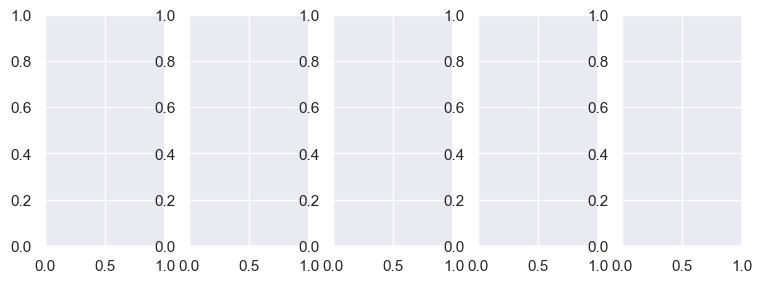

In [54]:
SAMPLES_IDXs = [12000, 16000, 18000, 22000, 24000] # 1316, 41526, 2315

for i in range(1000, 2000):
    SAMPLES_IDXs = [x+i for x in SAMPLES_IDXs]
    searching_for_good_looking_respones(SAMPLES_IDXs)

24006 - center left out of box
12010 - upper top scatter not centered
22055 - center like right small central
18078 - top center centered and nice scattered
12435, 32515 - centered centered verticaly between top and center
22465 - small centered response in the bottom
22595 - centered response vertically between center and bottom, shifted to the right
13378 - centered center, shifted to the left
23891, 19570 - centered, shifted to the center top
20016 - centered with two center maxes
26080 - centered, to with small radius
14628 - scattered all over the top
23886 - centered center like
30015, 18670 - centered, center to the left
32028 - centeted, center shifted to the right
27628 - centered, top shifted to the bottom

In [75]:
def generate_and_save_images_sdigan(test_input, SAMPLES_IDXs):
    # produce predictions
    predictions_sdingan_1 = sdingan_1(test_input, training=False)
    predictions_sdingan_2 = sdingan_2(test_input, training=False)

    fig, axs = plt.subplots(3, len(SAMPLES_IDXs), figsize=(25, 5))
    # plt.title(SAMPLES_IDXs, x=0.1, horizontalalignment='left')
    im_in_row = []
    for i in range(0, len(SAMPLES_IDXs)*3):
        if i < len(SAMPLES_IDXs):
            # Real Neutron
            title_model = "True Proton samples"
            row = 0
            x = x_test[SAMPLES_IDXs][i % len(SAMPLES_IDXs)].reshape(56, 30)
        elif i >= len(SAMPLES_IDXs) and i < 2*len(SAMPLES_IDXs):
            # VAE model
            title_model = "SDIGAN 70 + intensity  reg"
            row = 1
            x = predictions_sdingan_1[i % len(SAMPLES_IDXs)].numpy().reshape(56, 30)
        elif i >= 2*len(SAMPLES_IDXs):
            title_model = "SDIGAN 96 + intensity reg"
            # GAN model
            row = 2
            x = predictions_sdingan_2[i % len(SAMPLES_IDXs)].numpy().reshape(56, 30)

        axs[row, len(SAMPLES_IDXs)//2].set_title(title_model, fontsize=15)
        im = axs[row, i % len(SAMPLES_IDXs)].imshow(x, cmap='gnuplot')
        axs[row, i % len(SAMPLES_IDXs)].axis('off')
        im_in_row.append(im)

    plt.tight_layout()
    plt.savefig(f"Thesis images/{'_'.join([str(x) for x in SAMPLES_IDXs])}.png", dpi=300)
    # plt.close()

In [58]:
import re
he = """
24006 - center left out of box -
12010 - upper top scatter not centered -
22055 - center like right small central -
18078 - top center centered and nice scattered -
12435, 32515 - centered centered verticaly between top and center -
22465 - small centered response in the bottom -
22595 - centered response vertically between center and bottom, shifted to the right
13378 - centered center, shifted to the left
23891, 19570 - centered, shifted to the center top
20016 - centered with two center maxes
26080 - centered, to with small radius
14628 - scattered all over the top
23886 - centered center like
30015, 18670 - centered, center to the left
32028 - centeted, center shifted to the right
27628 - centered, top shifted to the bottom
"""
numbers = re.findall(r'\d+', he)
print(numbers)

['24006', '12010', '22055', '18078', '12435', '32515', '22465', '22595', '13378', '23891', '19570', '20016', '26080', '14628', '23886', '30015', '18670', '32028', '27628']


0


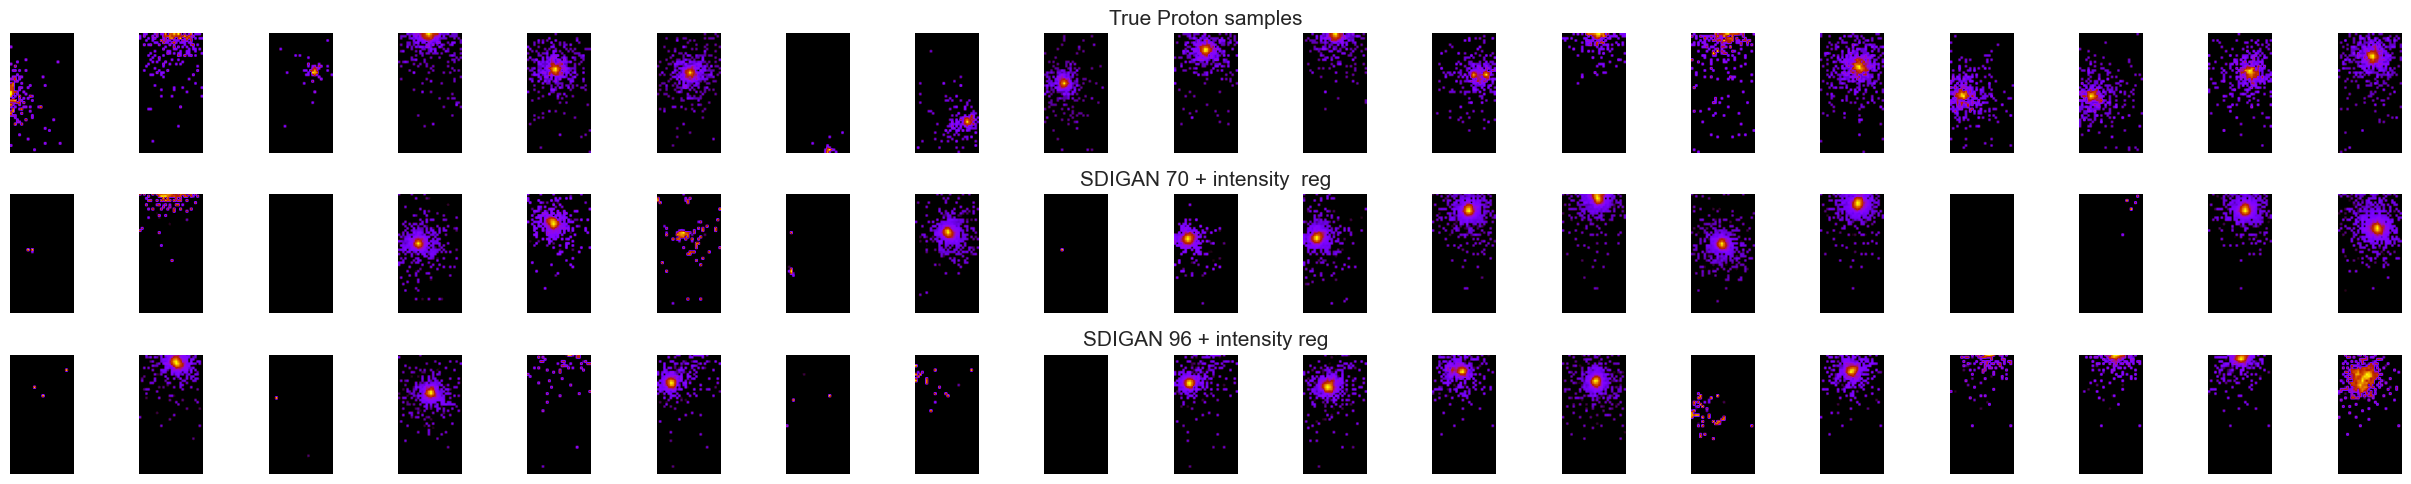

In [77]:
# for h in range(1101, 1201):
SAMPLES_IDXs = ['24006', '12010', '22055', '18078', '12435', '32515', '22465', '22595', '13378', '23891', '19570', '20016', '26080', '14628','23886', '30015', '18670', '32028', '27628']
SAMPLES_IDXs = [int(x) for x in SAMPLES_IDXs]
num_examples_to_generate = len(SAMPLES_IDXs)
noise_dim = 10

for i in range(0, 1):
    print(i)
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    seed_cond = y_test[SAMPLES_IDXs]
    generate_and_save_images_sdigan([seed, seed_cond], SAMPLES_IDXs)

In [28]:
for h in range(1301, 1351):
    SAMPLES_IDXs = [22394, 783, 22354, 40807, 715] # 1316, 41526, 2315
    # 2641, 21708, 113, 101
    # 113, 84, 41070, 41526, 101, 20016
    # 2641, 113, 782, 41526, 2315
    # 41070, 1381, 782, 21308, 2
    # 22242, 21708, 604, 22220, 40643
    # 40807, 783, 22354, 736, 715
    # 41824, 1742
    SAMPLES_IDXs = [x+h for x in SAMPLES_IDXs]
    num_examples_to_generate = len(SAMPLES_IDXs)
    noise_dim = 10

    for i in range(0, 1):
        seed = tf.random.normal([num_examples_to_generate, noise_dim])
        seed_cond = y_test[SAMPLES_IDXs]
        generate_and_save_images([seed, seed_cond], SAMPLES_IDXs, i)

IndexError: index 23695 is out of bounds for axis 0 with size 9743

#### Plot aux reg

In [22]:
def generate_and_save_images_sdigan_aux(test_input, SAMPLES_IDXs):
    # produce predictions
    predictions_sdingan_aux = sdingan_aux(test_input, training=False)

    fig, axs = plt.subplots(2, len(SAMPLES_IDXs), figsize=(25, 5))
    # plt.title(SAMPLES_IDXs, x=0.1, horizontalalignment='left')
    im_in_row = []
    for i in range(0, len(SAMPLES_IDXs)*2):
        if i < len(SAMPLES_IDXs):
            # Real Neutron
            title_model = "True Proton samples"
            row = 0
            x = x_test[SAMPLES_IDXs][i % len(SAMPLES_IDXs)].reshape(56, 30)
        elif i >= len(SAMPLES_IDXs) and i < 2*len(SAMPLES_IDXs):
            # VAE model
            title_model = "SDIGAN AUX REG + intensity reg"
            row = 1
            x = predictions_sdingan_aux[i % len(SAMPLES_IDXs)].numpy().reshape(56, 30)

        axs[row, len(SAMPLES_IDXs)//2].set_title(title_model, fontsize=15)
        im = axs[row, i % len(SAMPLES_IDXs)].imshow(x, cmap='gnuplot')
        axs[row, i % len(SAMPLES_IDXs)].axis('off')
        im_in_row.append(im)

    plt.tight_layout()
    plt.savefig(f"Thesis images/aux_reg_1_min_photonsum{'_'.join([str(x) for x in SAMPLES_IDXs])}.png", dpi=300)
    # plt.close()

0


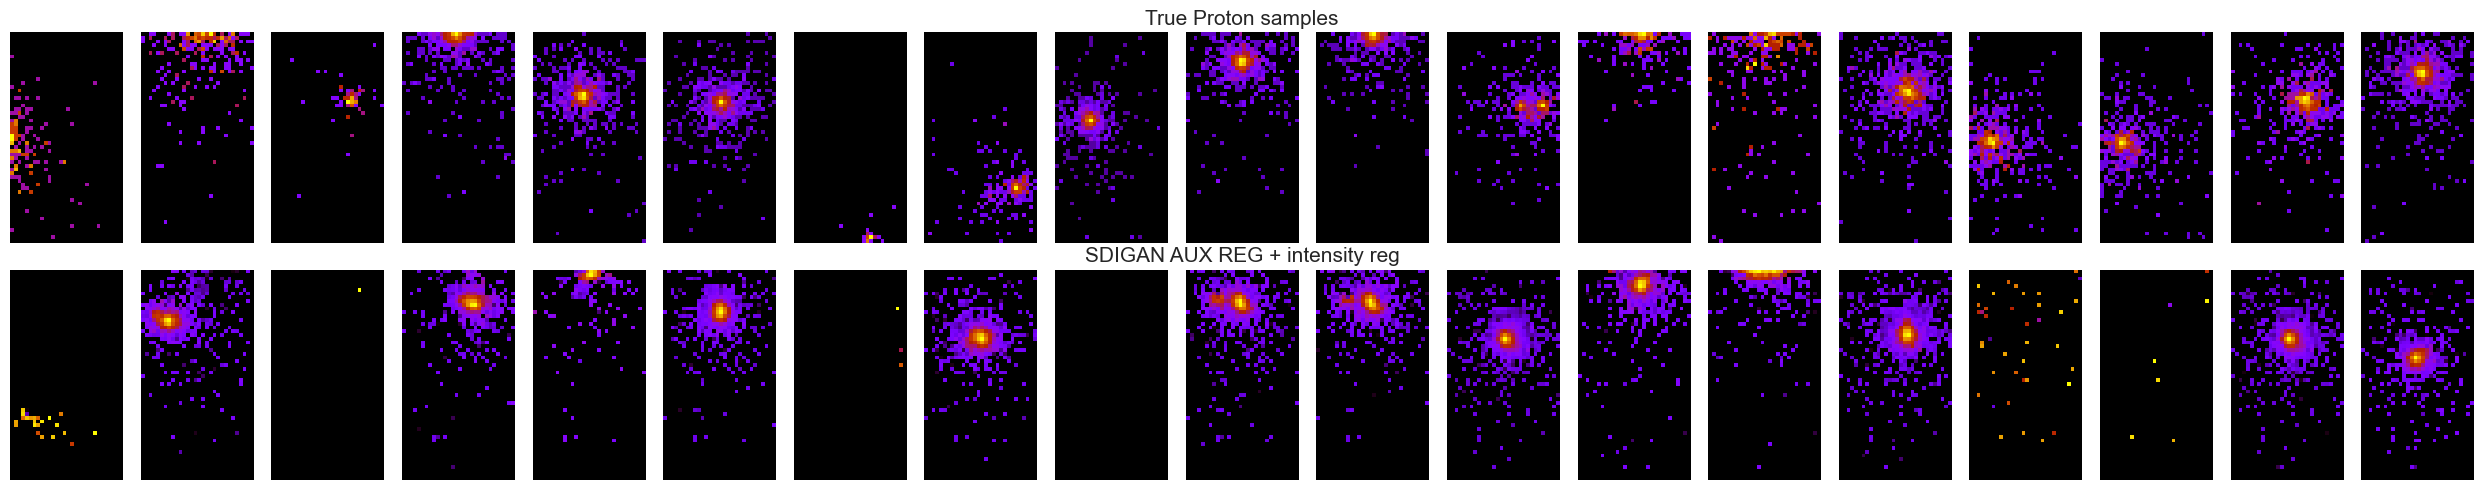

In [28]:
# for h in range(1101, 1201):
SAMPLES_IDXs = ['24006', '12010', '22055', '18078', '12435', '32515', '22465', '22595', '13378', '23891', '19570', '20016', '26080', '14628','23886', '30015', '18670', '32028', '27628']
SAMPLES_IDXs = [int(x) for x in SAMPLES_IDXs]
num_examples_to_generate = len(SAMPLES_IDXs)
noise_dim = 10

for i in range(0, 1):
    print(i)
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    seed_cond = y_test[SAMPLES_IDXs]
    generate_and_save_images_sdigan_aux([seed, seed_cond], SAMPLES_IDXs)

### Plot different number of photon sum

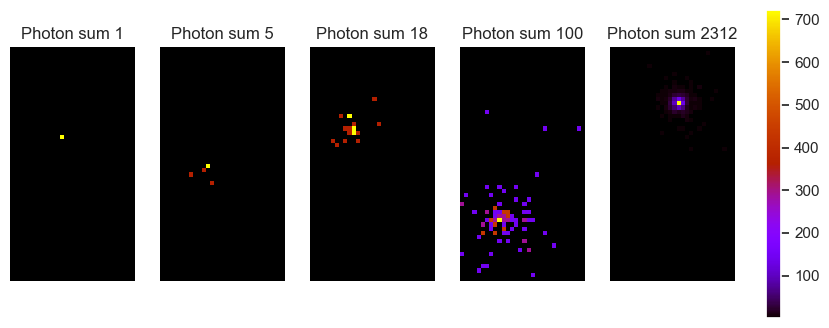

In [5]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

idx_1 = data_cond[data_cond.proton_photon_sum == 1].index[2]
idx_5 = data_cond[data_cond.proton_photon_sum == 5].index[45]
idx_18 = data_cond[data_cond.proton_photon_sum == 18].index[44]
idx_100 = data_cond[data_cond.proton_photon_sum == 100].index[3]

fig, axs = plt.subplots(1, 5, figsize=(8, 3))
min_pixel = 1
max_pixel = 1
for i, (idx, name) in enumerate(zip([idx_1, idx_5, idx_18, idx_100], ["1", "5", "18", "100"])):
    x = data[idx]
    title_model = f"Photon sum {name}"
    axs[i].set_title(title_model, fontsize=12)
    im = axs[i].imshow(x, cmap='gnuplot')

    max_val = np.max(x)
    if max_val > max_pixel:
        max_pixel = max_val

    axs[i].axis("off")

norm = mcolors.Normalize(vmin=min_pixel, vmax=max_pixel)
sm = cm.ScalarMappable(norm=norm, cmap='gnuplot')
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.025, pad=0.04)

# plt.tight_layout()
plt.savefig(f"Thesis images/examples_sample_different_photonsums.png", dpi=300)

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

idx_1 = data_cond[data_cond.proton_photon_sum == 1].index[2]
idx_5 = data_cond[data_cond.proton_photon_sum == 5].index[45]
idx_18 = data_cond[data_cond.proton_photon_sum == 18].index[44]
idx_100 = data_cond[data_cond.proton_photon_sum == 100].index[3]

fig, axs = plt.subplots(1, 5, figsize=(8, 3))
min_pixel = 1
max_pixel = 1
for i, (idx, name) in enumerate(zip([idx_1, idx_5, idx_18, idx_100], ["1", "5", "18", "100"])):
    x = data[idx]
    title_model = f"Photon sum {name}"
    axs[i].set_title(title_model, fontsize=12)
    im = axs[i].imshow(x, cmap='gnuplot')

    max_val = np.max(x)
    if max_val > max_pixel:
        max_pixel = max_val

    axs[i].axis("off")

norm = mcolors.Normalize(vmin=min_pixel, vmax=max_pixel)
sm = cm.ScalarMappable(norm=norm, cmap='gnuplot')
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.025, pad=0.04)

# plt.tight_layout()
plt.savefig(f"Thesis images/examples_sample_different_photonsums.png", dpi=300)

## Calculate time of generation

In [74]:
import timeit
N_OF_EXPERIMENTS_TO_GENERATE = 10

In [75]:
print("Number of samples for each experiment: {}".format(len(y_test)))

Number of samples for each experiment: 68846


In [83]:
from tabulate import tabulate

def plot_statistics(time_results):
    """
    Plots statistics of running execution time for experimets.
    :param time_resutls: List of execution time of each experiment.
    """
    stats_table = [
        ["Min: ", min(time_results)],
        ["Max: ", max(time_results)],
        ["Mean: ", np.mean(time_results)],
        ["Stddev: ", np.std(time_results)],
    ]
    table = tabulate(stats_table, tablefmt="github")
    table_title = "Execution time of experiment"
    full_table = f"{table_title}\n\n{table}"
    print(full_table)

n_generations = 1000

### Measure execution times

In [84]:
#
# VAE
#
def generate_test_vae():
    num_examples_to_generate, noise_dim = n_generations, 10
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    output = vae.predict([seed, y_test[:n_generations]])

In [85]:
execution_time_vae = timeit.repeat(generate_test_vae, repeat=N_OF_EXPERIMENTS_TO_GENERATE, number=1)
plot_statistics(execution_time_vae)

32/32 [==============================] - 0s 10ms/step
Execution time of experiment

|---------|-----------|
| Min:    | 0.429465  |
| Max:    | 0.764346  |
| Mean:   | 0.471816  |
| Stddev: | 0.0977088 |


In [86]:
#
# GAN
#
def generate_test_gan():
    num_examples_to_generate, noise_dim = n_generations, 10
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    output = gan.predict([seed, y_test[:n_generations]])

In [87]:
execution_time_gan = timeit.repeat(generate_test_gan, repeat=N_OF_EXPERIMENTS_TO_GENERATE, number=1)
plot_statistics(execution_time_gan)

32/32 [==============================] - 1s 24ms/step
Execution time of experiment

|---------|-----------|
| Min:    | 0.857535  |
| Max:    | 0.911849  |
| Mean:   | 0.872069  |
| Stddev: | 0.0146469 |


In [88]:
#
# SDI-GAN
#
def generate_test_sdigan():
    num_examples_to_generate, noise_dim = n_generations, 10
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    output = sdigan.predict([seed, y_test[:n_generations]])

In [89]:
execution_time_sdigan = timeit.repeat(generate_test_sdigan, repeat=N_OF_EXPERIMENTS_TO_GENERATE, number=1)
plot_statistics(execution_time_sdigan)

32/32 [==============================] - 1s 25ms/step
Execution time of experiment

|---------|-----------|
| Min:    | 0.860747  |
| Max:    | 0.913597  |
| Mean:   | 0.881975  |
| Stddev: | 0.0165553 |


In [90]:
#
# SDI-GAN + reg
#
def generate_test_sdingan():
    num_examples_to_generate, noise_dim = n_generations, 10
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    output = sdingan_reg.predict([seed, y_test[:n_generations]])

In [91]:
execution_time_sdingan = timeit.repeat(generate_test_sdingan, repeat=N_OF_EXPERIMENTS_TO_GENERATE, number=1)
plot_statistics(execution_time_sdingan)

32/32 [==============================] - 1s 27ms/step
Execution time of experiment

|---------|-----------|
| Min:    | 0.888592  |
| Max:    | 0.957098  |
| Mean:   | 0.915824  |
| Stddev: | 0.0223993 |


In [93]:
#
# SDI-GAN + reg + aux reg
#
def generate_test_sdingan_aux():
    num_examples_to_generate, noise_dim = n_generations, 10
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    output = sdingan_reg_aux.predict([seed, y_test[:n_generations]])


execution_time_sdingan = timeit.repeat(generate_test_sdingan_aux, repeat=N_OF_EXPERIMENTS_TO_GENERATE, number=1)
plot_statistics(execution_time_sdingan)

32/32 [==============================] - 1s 27ms/step
Execution time of experiment

|---------|-----------|
| Min:    | 0.897601  |
| Max:    | 1.02085   |
| Mean:   | 0.978981  |
| Stddev: | 0.0310817 |
32/32 [==============================] - 1s 29ms/step
Execution time of experiment

|---------|-----------|
| Min:    | 0.963659  |
| Max:    | 1.06983   |
| Mean:   | 1.01769   |
| Stddev: | 0.0313507 |


## Calculate number of empty responses

In [48]:
def get_number_of_empty_responses(model, noise_dim = 10, n_executions=5):
    # list_n_empty_responses = []
    # for _ in range(n_executions):
    seed = tf.random.normal([len(y_test[:N_EXAMPLES]), noise_dim])
    input_data = [seed, y_test[:N_EXAMPLES]]

    outputs = model(input_data, training=False)
    pixel_sum = tf.reduce_sum(outputs[:,:,:,0], axis=(1, 2))
    indices_of_empty_responses = tf.where(tf.equal(pixel_sum, 0))
    n_empty_responses = len(indices_of_empty_responses.numpy())
    # list_n_empty_responses.append(n_empty_responses)
    # return sum(n_empty_responses)/n_executions
    return n_empty_responses

In [53]:
#
# VAE
#
n_empty_responses_gan = get_number_of_empty_responses(vae)
n_empty_responses_gan

5

In [54]:
#
# GAN
#
n_empty_responses_gan = get_number_of_empty_responses(gan)
n_empty_responses_gan

15

In [55]:
#
# SDI-GAN
#
n_empty_responses_gan = get_number_of_empty_responses(sdigan)
n_empty_responses_gan

0

In [56]:
#
# SDIN-GAN
#
n_empty_responses_gan = get_number_of_empty_responses(sdingan)
n_empty_responses_gan

6

## Histogram plots

In [72]:
def get_channels_dist_from_proton_model(generator, z, z_c, scale):
    results = generator.predict([z, z_c])
    results = np.exp(results)-1
    results = results*scale

    ch_gen = np.array(results).reshape(-1, 56, 30)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    return ch_gen

2152/2152 [==============================] - 68s 32ms/step


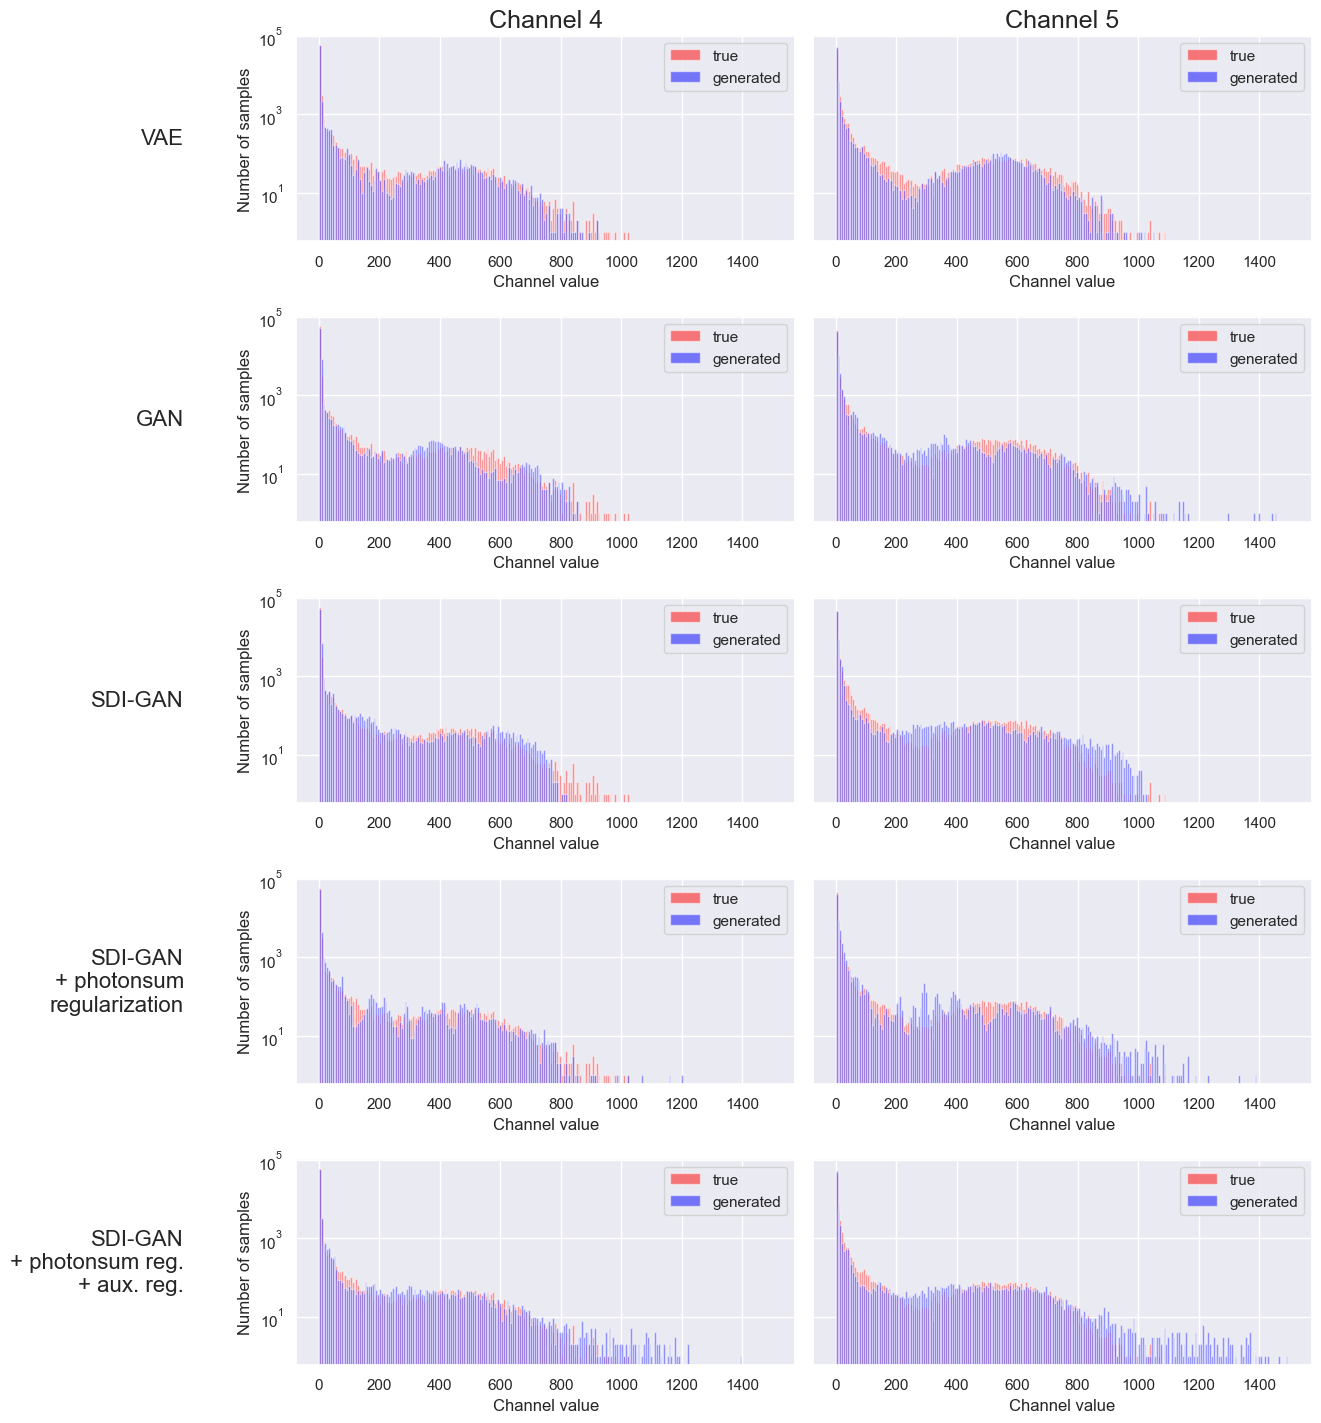

In [73]:
# def make_histograms_of_channels(scale=1, noise_std=1, noise_dim=10):
scale=1
noise_std=1
noise_dim=10
z = np.random.normal(0, noise_std, (x_test.shape[0], noise_dim))
z_c = y_test

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
models_dist_vae = get_channels_dist_from_proton_model(vae, z, z_c, scale)
models_dist_gan = get_channels_dist_from_proton_model(gan, z, z_c, scale)
models_dist_sdigan = get_channels_dist_from_proton_model(sdigan, z, z_c, scale)
models_dist_sdigan_reg = get_channels_dist_from_proton_model(sdingan_reg, z, z_c, scale)
models_dist_sdigan_reg_aux = get_channels_dist_from_proton_model(sdingan_reg_aux, z, z_c, scale)

fig, axis = plt.subplots(5, 2, figsize=(12, 16), sharex=False, sharey=True)

axis[0, 0].set_title('Channel 4', fontsize=18)
axis[0, 1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for i, model_data in enumerate([models_dist_vae, models_dist_gan, models_dist_sdigan, models_dist_sdigan_reg, models_dist_sdigan_reg_aux]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[i][j].hist(ch_org[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[i][j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[i][j].legend(loc='upper right')
        if j == 0:
            axis[i][j].set_ylabel('Number of samples')
        axis[i][j].set_xlabel('Channel value')
        axis[i][j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

row_titles = ['VAE', 'GAN', 'SDI-GAN', 'SDI-GAN\n+ photonsum\nregularization', 'SDI-GAN\n+ photonsum reg.\n+ aux. reg.']
for ax, row in zip(axis[:,0], row_titles):
    # Use the y-position of the axis and add a text to the figure
    fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
             va='center', ha='right', rotation='horizontal', fontsize=16)

fig.savefig("Thesis images/histograms_4_5_channels_full_1.png")
plt.show()

# Min 5 sumphotons proton data

In [18]:
data_cond = pd.read_pickle('../data/data_cond_photonsum_proton_5_2312.pkl')
data = pd.read_pickle('../data/data_photonsum_proton_5_2312.pkl')

In [19]:
proton_photon_sum = data_cond['proton_photon_sum']
std_proton = data_cond['std_proton']

In [20]:
data_cond.drop(columns=['proton_photon_sum', 'std_proton'], inplace=True)

In [21]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge
0,1304.340,-0.000018,0.000016,0.050293,-0.509192,0.461106,1304.340,0.000000,0.0
1,325.158,0.000000,0.000000,0.000000,0.269915,-0.081921,325.157,139.570610,-1.0
2,3192.380,0.000000,0.000000,0.000000,0.022422,-0.182957,-3192.380,939.565413,0.0
3,2082.630,0.000000,0.000000,0.000000,-0.171176,0.281748,2082.630,938.272081,1.0
4,174.401,0.000005,0.000002,-0.002588,0.292035,0.104749,-174.400,0.000000,0.0


#### Preprocess data

In [22]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data max 6.641182 min 0.0


In [23]:
scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

cond max 20.755913 min -19.050192


In [24]:
data_cond.mean(), data_cond.std(), std_proton.min(), std_proton.max()

(2.3328357e-09, 0.9999999, 0.0, 1.0)

In [25]:
_, x_test, _, y_test, std_train, std_test = train_test_split(data, data_cond, std_proton, test_size=0.2, shuffle=False)
print(x_test.shape, y_test.shape, std_test.shape, std_train.shape)

(37220, 56, 30) (37220, 9) (37220,) (148877,)


## Load models

In [100]:
sdingan_286 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\min_5_proton\\gen_sin-gan_286.h5",
    compile=False)
sdingan_88 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\min_5_proton\\gen_sin-gan_88.h5",
    compile=False)

### Function for calculating sum of channels

### Calculate channels for original simulation test data

In [97]:
org = np.exp(x_test)-1
ch_org = np.array(org).reshape(-1, 56, 30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values

In [98]:
org.shape
del org

### Define functions for calculating WS

In [99]:
def calculate_ws_ch(generator,
                    x_test, y_test,
                    ch_org, data_shape,
                    n_calc=5,
                    scale=1, noise_std=1):
    """
    Calculates ws distance for each channel separately.
    """
    ws = [0, 0, 0, 0, 0]
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (x_test.shape[0], 10))
        z_c = y_test
        results = generator.predict([z, z_c])
        results = np.exp(results) - 1
        results = results * scale

        ch_gen = np.array(results).reshape(data_shape)
        ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
        for i in range(5):
            ws[i] = ws[i] + wasserstein_distance(ch_org[:, i], ch_gen[:, i])
        ws = np.array(ws)

    ws = ws / n_calc
    print("\n", "-" * 30, "\n")
    print("ws mean", f'{ws.sum() / 5:.2f}', end=" ")
    for n, score in enumerate(ws):
        print("ch" + str(n + 1), f'{score:.2f}', end=" ")

## Calculate ws

In [101]:
# SDI-GAN
calculate_ws_ch(sdingan_286,
                x_test, y_test,
                ch_org, (-1, 56, 30))

1164/1164 [==============================] - 36s 31ms/step

 ------------------------------ 

ws mean 3.45 ch1 1.36 ch2 0.87 ch3 1.85 ch4 6.19 ch5 6.99 

In [102]:
# SDIN-GAN
calculate_ws_ch(sdingan_88,
                x_test, y_test,
                ch_org, (-1, 56, 30))

1164/1164 [==============================] - 34s 29ms/step

 ------------------------------ 

ws mean 2.86 ch1 1.11 ch2 1.13 ch3 1.90 ch4 3.03 ch5 7.12 

## Test models diversity

1. generate 5 samples for every conditional data and calculate std within this groups

In [103]:
from sklearn.metrics import mean_absolute_error

In [104]:
def model_diversity(generator,
                    y_test, std_test,
                    n_calc=10,
                    noise_std=1):
    """
    Performs n_calculations for the same x_test, y_test data and saves images to list.
    """
    n_samples = y_test.shape[0]
    images_data = np.ndarray(shape=(n_samples, 1680, n_calc))
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (n_samples, 10))
        z_c = y_test
        results = generator.predict([z, z_c])
        results = np.exp(results) - 1

        # 1. flatten responses
        flatten_responses = results.reshape(len(results), -1)  # (n_samples, 1680)
        flatten_responses = flatten_responses.reshape(n_samples, -1, 1)
        images_data = np.append(images_data, flatten_responses, axis=2)

    return mean_absolute_error(np.std(images_data, axis=2).sum(axis=1), std_test.values)
    #
    #     ch_gen = np.array(results).reshape(data_shape)
    #     ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    #     for i in range(5):
    #         ws[i] = ws[i] + wasserstein_distance(ch_org[:, i], ch_gen[:, i])
    #     ws = np.array(ws)
    #
    # ws = ws / n_calc
    # print("\n", "-" * 30, "\n")
    # print("ws mean", f'{ws.sum() / 5:.2f}', end=" ")
    # for n, score in enumerate(ws):
    #     print("ch" + str(n + 1), f'{score:.2f}', end=" ")

In [105]:
diversity_loss = model_diversity(sdingan_286, y_test, std_test, n_calc=10)
diversity_loss

1164/1164 [==============================] - 31s 27ms/step


206.4495798770115

In [106]:
diversity_loss = model_diversity(sdingan_88, y_test, std_test, n_calc=10)
diversity_loss

1164/1164 [==============================] - 32s 27ms/step


176.04428146730257

Plot distribution of number of photons

## Plot samples

In [48]:
def generate_and_save_images(test_input, SAMPLES_IDXs, k):
    # produce predictions
    predictions_vae = vae(test_input, training=False)
    predictions_gan = gan(test_input, training=False)
    predictions_sdigan = sdigan(test_input, training=False)
    predictions_sdingan = sdingan(test_input, training=False)

    fig, axs = plt.subplots(5, 5, figsize=(13, 16))
    # plt.title(SAMPLES_IDXs, x=0.1, horizontalalignment='left')
    im_in_row = []
    for i in range(0, 25):
        if i < 5:
            # Real Neutron
            title_model = "True Proton samples"
            row = 0
            x = x_test[SAMPLES_IDXs][i % 5].reshape(56, 30)
        elif i >= 5 and i < 10:
            # VAE model
            title_model = "VAE responses"
            row = 1
            x = predictions_vae[i % 5].numpy().reshape(56, 30)
        elif i >= 10 and i < 15:
            title_model = "GAN responses"
            # GAN model
            row = 2
            x = predictions_gan[i % 5].numpy().reshape(56, 30)
        elif i >= 15 and i < 20:
            # SDI-GAN model
            title_model = "SDI-GAN responses"
            row = 3
            x = predictions_sdigan[i % 5].numpy().reshape(56, 30)
        else:
            title_model = "SDIN-GAN responses"
            # SDIN-GAN model
            row = 4
            x = predictions_sdingan[i % 5].numpy().reshape(56, 30)

        axs[row, 2].set_title(title_model, fontsize=15)
        im = axs[row, i % 5].imshow(x, cmap='gnuplot')
        axs[row, i % 5].axis('off')
        im_in_row.append(im)

        # add colorbar to the last image, but scale is with respect to the all images in row
        if i % 5 == 4:
            fig.colorbar(im, ax=axs[i // 5, :])
            # fig.colorbar.set_ylim(0, 4)
            # axs[row].colorbar(predictions_per_row, ax=axs[i % 5])
            # predictions_per_row = []
    # plt.tight_layout()
    # plt.savefig(f"Thesis images/test/{'_'.join([str(x) for x in SAMPLES_IDXs])}_{k}.png", dpi=300)
    # plt.close()

In [111]:
def searching_for_good_looking_respones(SAMPLES_IDXs):

    fig, axs = plt.subplots(1, 5, figsize=(9, 3))

    for i in range(0, 5):
        # Real Neutron
        title_model = "True Proton samples"
        x = x_test[SAMPLES_IDXs][i % 5].reshape(56, 30)

        axs[2].set_title(f"{SAMPLES_IDXs}", fontsize=15)
        im = axs[i].imshow(x, cmap='gnuplot')
        axs[i % 5].axis('off')

    plt.tight_layout()
    plt.savefig(f"Thesis images/good_proton_responses_5_min/{'_'.join([str(x) for x in SAMPLES_IDXs])}.png", dpi=60)
    plt.close()

IndexError: index 37425 is out of bounds for axis 0 with size 37220

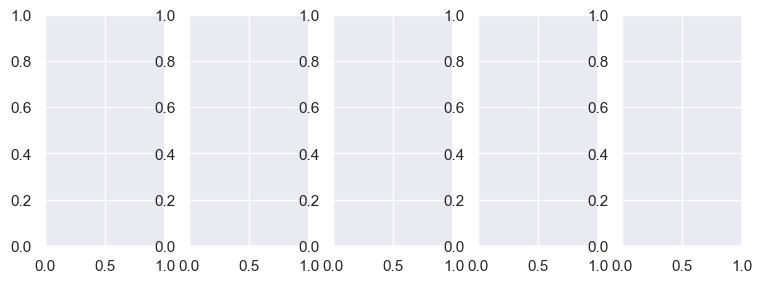

In [115]:
SAMPLES_IDXs = [2000, 6000, 8000, 10000, 12000] # 1316, 41526, 2315

for i in range(0, 1000):
    SAMPLES_IDXs = [x+i for x in SAMPLES_IDXs]
    searching_for_good_looking_respones(SAMPLES_IDXs)

2001 - center, center bottom shifted to left
12003
6010
8010
10021
8028
10045
6120
10153
8253
10253
10351
10435
6630
6703
2703
12946
6946
7081
11326

In [109]:
def generate_and_save_images_sdigan(test_input, SAMPLES_IDXs):
    # produce predictions
    predictions_sdingan_286 = sdingan_286(test_input, training=False)
    predictions_sdingan_88 = sdingan_88(test_input, training=False)

    fig, axs = plt.subplots(3, len(SAMPLES_IDXs), figsize=(25, 5))
    # plt.title(SAMPLES_IDXs, x=0.1, horizontalalignment='left')
    im_in_row = []
    for i in range(0, len(SAMPLES_IDXs)*3):
        if i < len(SAMPLES_IDXs):
            # Real Neutron
            title_model = "True Proton samples"
            row = 0
            x = x_test[SAMPLES_IDXs][i % len(SAMPLES_IDXs)].reshape(56, 30)
        elif i >= len(SAMPLES_IDXs) and i < 2*len(SAMPLES_IDXs):
            # VAE model
            title_model = "SDIGAN 286 + intensity  reg"
            row = 1
            x = predictions_sdingan_286[i % len(SAMPLES_IDXs)].numpy().reshape(56, 30)
        elif i >= 2*len(SAMPLES_IDXs):
            title_model = "SDIGAN 88 + intensity reg"
            # GAN model
            row = 2
            x = predictions_sdingan_88[i % len(SAMPLES_IDXs)].numpy().reshape(56, 30)

        axs[row, len(SAMPLES_IDXs)//2].set_title(title_model, fontsize=15)
        im = axs[row, i % len(SAMPLES_IDXs)].imshow(x, cmap='gnuplot')
        axs[row, i % len(SAMPLES_IDXs)].axis('off')
        im_in_row.append(im)

    plt.tight_layout()
    plt.savefig(f"Thesis images/5_min_photonsum{'_'.join([str(x) for x in SAMPLES_IDXs])}.png", dpi=300)
    # plt.close()

0


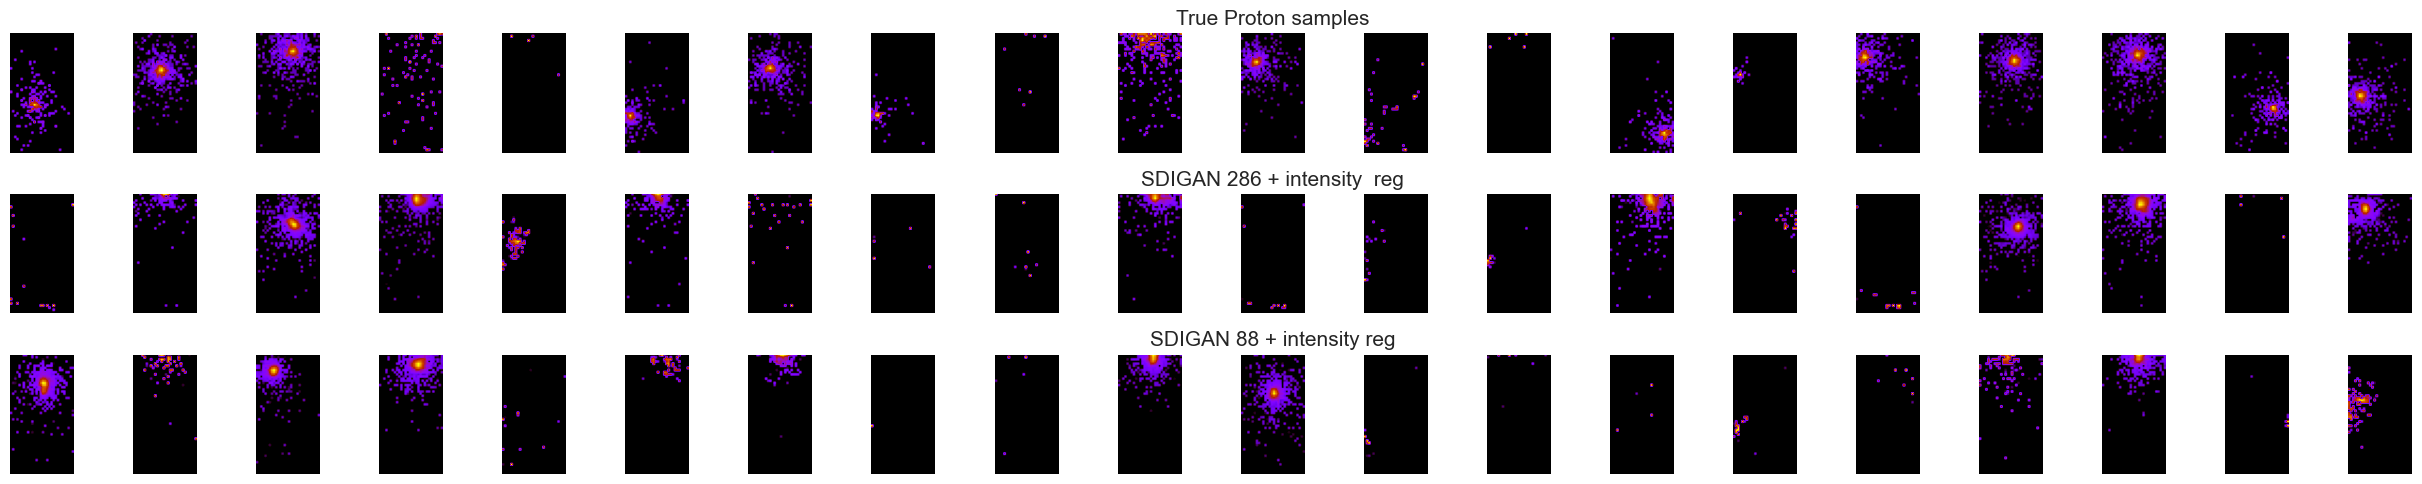

In [118]:
# for h in range(1101, 1201):
SAMPLES_IDXs = [2001,
12003,
6010,
8010,
10021,
8028,
10045,
6120,
10153,
8253,
10253,
10351,
10435,
6630,
6703,
2703,
12946,
6946,
7081,
11326]
SAMPLES_IDXs = [int(x) for x in SAMPLES_IDXs]
num_examples_to_generate = len(SAMPLES_IDXs)
noise_dim = 10

for i in range(0, 1):
    print(i)
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    seed_cond = y_test[SAMPLES_IDXs]
    generate_and_save_images_sdigan([seed, seed_cond], SAMPLES_IDXs)

## Calculate time of generation

In [119]:
import timeit
N_OF_EXPERIMENTS_TO_GENERATE = 10

In [120]:
print("Number of samples for each experiment: {}".format(len(y_test)))

Number of samples for each experiment: 37220


In [121]:
from tabulate import tabulate

def plot_statistics(time_results):
    """
    Plots statistics of running execution time for experimets.
    :param time_resutls: List of execution time of each experiment.
    """
    stats_table = [
        ["Min: ", min(time_results)],
        ["Max: ", max(time_results)],
        ["Mean: ", np.mean(time_results)],
        ["Stddev: ", np.std(time_results)],
    ]
    table = tabulate(stats_table, tablefmt="github")
    table_title = "Execution time of experiment"
    full_table = f"{table_title}\n\n{table}"
    print(full_table)

### Measure execution times

In [123]:
n_generations = 1000

In [124]:
#
# SDIN-GAN 286
#
def generate_test_sdingan_286():
    num_examples_to_generate, noise_dim = n_generations, 10
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    output = sdingan_286.predict([seed, y_test[:n_generations]])

In [133]:
execution_time_sdingan_286 = timeit.repeat(generate_test_sdingan_286, repeat=N_OF_EXPERIMENTS_TO_GENERATE, number=1)
plot_statistics(execution_time_sdingan_286)

32/32 [==============================] - 1s 28ms/step
Execution time of experiment

|---------|-----------|
| Min:    | 0.883085  |
| Max:    | 1.19037   |
| Mean:   | 0.986545  |
| Stddev: | 0.0781793 |


In [126]:
n_generations = 1000

In [127]:
#
# SDIN-GAN 88
#
def generate_test_sdingan_88():
    num_examples_to_generate, noise_dim = n_generations, 10
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    output = sdingan_88.predict([seed, y_test[:n_generations]])

In [132]:
execution_time_sdingan_88 = timeit.repeat(generate_test_sdingan_286, repeat=N_OF_EXPERIMENTS_TO_GENERATE, number=1)
plot_statistics(execution_time_sdingan_88)

32/32 [==============================] - 1s 28ms/step
Execution time of experiment

|---------|-----------|
| Min:    | 0.899507  |
| Max:    | 1.09372   |
| Mean:   | 0.971868  |
| Stddev: | 0.0515447 |


## Calculate number of empty responses

## Histogram plots

In [134]:
def get_channels_dist_from_proton_model(generator, z, z_c, scale):
    results = generator.predict([z, z_c])
    results = np.exp(results)-1
    results = results*scale

    ch_gen = np.array(results).reshape(-1, 56, 30)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    return ch_gen

NameError: name 'models_dist_sdingan_286' is not defined

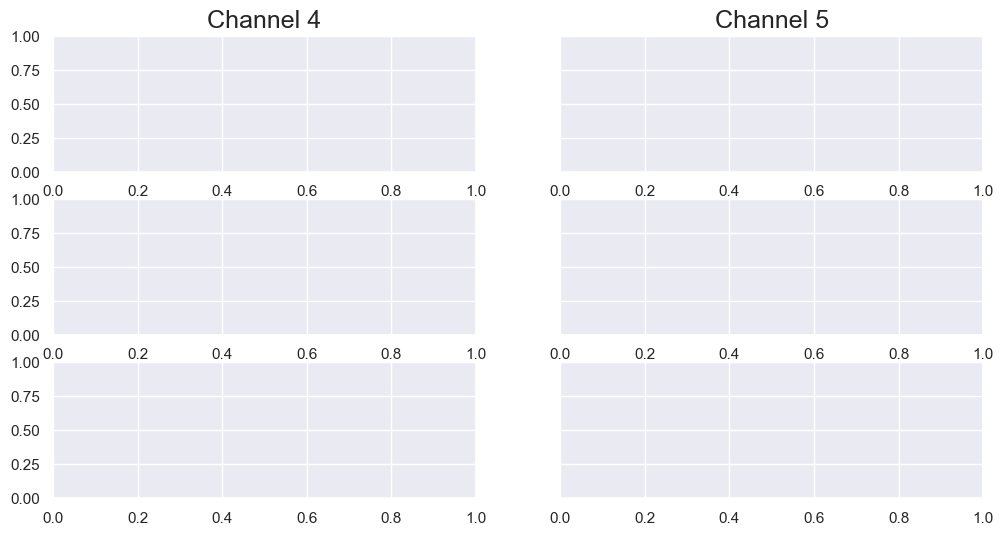

In [25]:
# def make_histograms_of_channels(scale=1, noise_std=1, noise_dim=10):
scale=1
noise_std=1
noise_dim=10
z = np.random.normal(0, noise_std, (x_test.shape[0], noise_dim))
z_c = y_test

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
# models_dist_sdingan_286 = get_channels_dist_from_proton_model(sdingan_286, z, z_c, scale)
# models_dist_sdingan_88 = get_channels_dist_from_proton_model(sdingan_88, z, z_c, scale)

fig, axis = plt.subplots(2, 2, figsize=(12, 6), sharex=False, sharey=True)

axis[0, 0].set_title('Channel 4', fontsize=18)
axis[0, 1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for i, model_data in enumerate([models_dist_sdingan_286, models_dist_sdingan_88]): #[models_dist_vae, models_dist_gan, models_dist_sdigan, models_dist_sdingan]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[i][j].hist(ch_org[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[i][j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[i][j].legend(loc='upper right')
        if j == 0:
            axis[i][j].set_ylabel('Number of samples')
        axis[i][j].set_xlabel('Channel value')
        axis[i][j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

row_titles = ['SDI-GAN 286', 'SDI-GAN 88']#['VAE', 'GAN', 'SDI-GAN', 'SDI-GAN\n+ photonsum\nregularization']
for ax, row in zip(axis[:,0], row_titles):
    # Use the y-position of the axis and add a text to the figure
    fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
             va='center', ha='right', rotation='horizontal', fontsize=16)


fig.savefig("Thesis images/histograms_4_5_channels_sdigans_5_min.png")
plt.show()

# Min 15 sumphotons proton data

In [147]:
data_cond = pd.read_pickle('../data/data_cond_stddev_photonsum_p_15_2133_n_15_3273.pkl')
data = pd.read_pickle('../data/data_proton_photonsum_proton_15_2133_neutron_15_3273.pkl')

In [149]:
proton_photon_sum = data_cond['proton_photon_sum']
std_proton = data_cond['std_proton']

In [150]:
data_cond.drop(columns=['proton_photon_sum', 'std_proton', 'group_number_proton', 'neutron_photon_sum', 'std_neutron', 'group_number_neutron'], inplace=True)

In [151]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge
0,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0
1,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0
2,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0
3,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0
4,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0


#### Preprocess data

In [152]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data max 6.5206213 min 0.0


In [153]:
scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

cond max 21.432093 min -35.632454


In [154]:
data_cond.mean(), data_cond.std(), std_proton.min(), std_proton.max()

(-3.5499639e-09, 0.99999994, 0.0, 1.0)

In [155]:
_, x_test, _, y_test, _, std_test = train_test_split(data, data_cond, std_proton, test_size=0.2, shuffle=False)
print(x_test.shape, y_test.shape, std_test.shape, group_test.shape)

(9743, 56, 30) (9743, 9) (9743,) (68846,)


## Load models

In [156]:
sdingan_190 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\min_15_proton\\gen_sin-gan_190.h5",
    compile=False)

### Function for calculating sum of channels

### Calculate channels for original simulation test data

In [157]:
org = np.exp(x_test)-1
ch_org = np.array(org).reshape(-1, 56, 30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values

In [158]:
org.shape
del org

### Define functions for calculating WS

In [159]:
def calculate_ws_ch(generator,
                    x_test, y_test,
                    ch_org, data_shape,
                    n_calc=5,
                    scale=1, noise_std=1):
    """
    Calculates ws distance for each channel separately.
    """
    ws = [0, 0, 0, 0, 0]
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (x_test.shape[0], 10))
        z_c = y_test
        results = generator.predict([z, z_c])
        results = np.exp(results) - 1
        results = results * scale

        ch_gen = np.array(results).reshape(data_shape)
        ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
        for i in range(5):
            ws[i] = ws[i] + wasserstein_distance(ch_org[:, i], ch_gen[:, i])
        ws = np.array(ws)

    ws = ws / n_calc
    print("\n", "-" * 30, "\n")
    print("ws mean", f'{ws.sum() / 5:.2f}', end=" ")
    for n, score in enumerate(ws):
        print("ch" + str(n + 1), f'{score:.2f}', end=" ")

## Calculate ws

In [160]:
# SDI-GAN
calculate_ws_ch(sdingan_190,
                x_test, y_test,
                ch_org, (-1, 56, 30))

305/305 [==============================] - 8s 28ms/step

 ------------------------------ 

ws mean 2.92 ch1 0.45 ch2 0.64 ch3 3.47 ch4 3.94 ch5 6.12 

## Test models diversity

1. generate 5 samples for every conditional data and calculate std within this groups

In [161]:
from sklearn.metrics import mean_absolute_error

In [162]:
def model_diversity(generator,
                    y_test, std_test,
                    n_calc=10,
                    noise_std=1):
    """
    Performs n_calculations for the same x_test, y_test data and saves images to list.
    """
    n_samples = y_test.shape[0]
    images_data = np.ndarray(shape=(n_samples, 1680, n_calc))
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (n_samples, 10))
        z_c = y_test
        results = generator.predict([z, z_c])
        results = np.exp(results) - 1

        # 1. flatten responses
        flatten_responses = results.reshape(len(results), -1)  # (n_samples, 1680)
        flatten_responses = flatten_responses.reshape(n_samples, -1, 1)
        images_data = np.append(images_data, flatten_responses, axis=2)

    return mean_absolute_error(np.std(images_data, axis=2).sum(axis=1), std_test.values)
    #
    #     ch_gen = np.array(results).reshape(data_shape)
    #     ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    #     for i in range(5):
    #         ws[i] = ws[i] + wasserstein_distance(ch_org[:, i], ch_gen[:, i])
    #     ws = np.array(ws)
    #
    # ws = ws / n_calc
    # print("\n", "-" * 30, "\n")
    # print("ws mean", f'{ws.sum() / 5:.2f}', end=" ")
    # for n, score in enumerate(ws):
    #     print("ch" + str(n + 1), f'{score:.2f}', end=" ")

In [163]:
diversity_loss = model_diversity(sdingan_190, y_test, std_test, n_calc=10)
diversity_loss

305/305 [==============================] - 9s 31ms/step


217.4160585384307

Plot distribution of number of photons

## Plot samples

In [164]:
def searching_for_good_looking_respones(SAMPLES_IDXs):

    fig, axs = plt.subplots(1, 5, figsize=(9, 3))

    for i in range(0, 5):
        # Real Neutron
        title_model = "True Proton samples"
        x = x_test[SAMPLES_IDXs][i % 5].reshape(56, 30)

        axs[2].set_title(f"{SAMPLES_IDXs}", fontsize=15)
        im = axs[i].imshow(x, cmap='gnuplot')
        axs[i % 5].axis('off')

    plt.tight_layout()
    plt.savefig(f"Thesis images/good_proton_responses_15_min/{'_'.join([str(x) for x in SAMPLES_IDXs])}.png", dpi=60)
    plt.close()

IndexError: index 9778 is out of bounds for axis 0 with size 9743

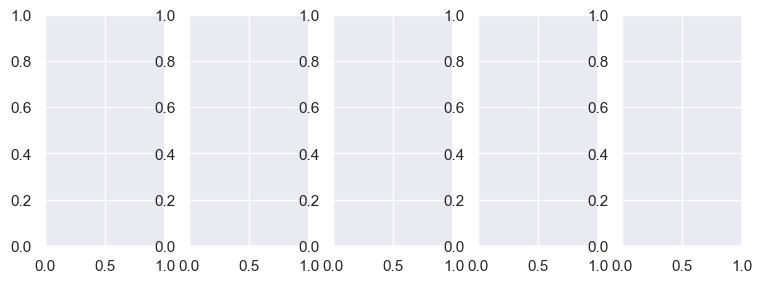

In [166]:
SAMPLES_IDXs = [0, 1000, 2000, 3000, 4000] # 1316, 41526, 2315

for i in range(0, 1000):
    SAMPLES_IDXs = [x+i for x in SAMPLES_IDXs]
    searching_for_good_looking_respones(SAMPLES_IDXs)

1001, 4006, 1010, 4015, 1015, 4028, 91, 136, 3136, 171, 1171,  1253, 2276, 2378, 378, 3528

In [172]:
def generate_and_save_images_sdigan(test_input, SAMPLES_IDXs):
    # produce predictions
    predictions_sdingan_190 = sdingan_190(test_input, training=False)

    fig, axs = plt.subplots(2, len(SAMPLES_IDXs), figsize=(25, 5))
    # plt.title(SAMPLES_IDXs, x=0.1, horizontalalignment='left')
    im_in_row = []
    for i in range(0, len(SAMPLES_IDXs)*2):
        if i < len(SAMPLES_IDXs):
            # Real Neutron
            title_model = "True Proton samples"
            row = 0
            x = x_test[SAMPLES_IDXs][i % len(SAMPLES_IDXs)].reshape(56, 30)
        elif i >= len(SAMPLES_IDXs) and i < 2*len(SAMPLES_IDXs):
            # VAE model
            title_model = "SDIGAN 190 + intensity  reg"
            row = 1
            x = predictions_sdingan_190[i % len(SAMPLES_IDXs)].numpy().reshape(56, 30)

        axs[row, len(SAMPLES_IDXs)//2].set_title(title_model, fontsize=15)
        im = axs[row, i % len(SAMPLES_IDXs)].imshow(x, cmap='gnuplot')
        axs[row, i % len(SAMPLES_IDXs)].axis('off')
        im_in_row.append(im)

    plt.tight_layout()
    plt.savefig(f"Thesis images/15_min_photonsum{'_'.join([str(x) for x in SAMPLES_IDXs])}.png", dpi=300)
    # plt.close()

0


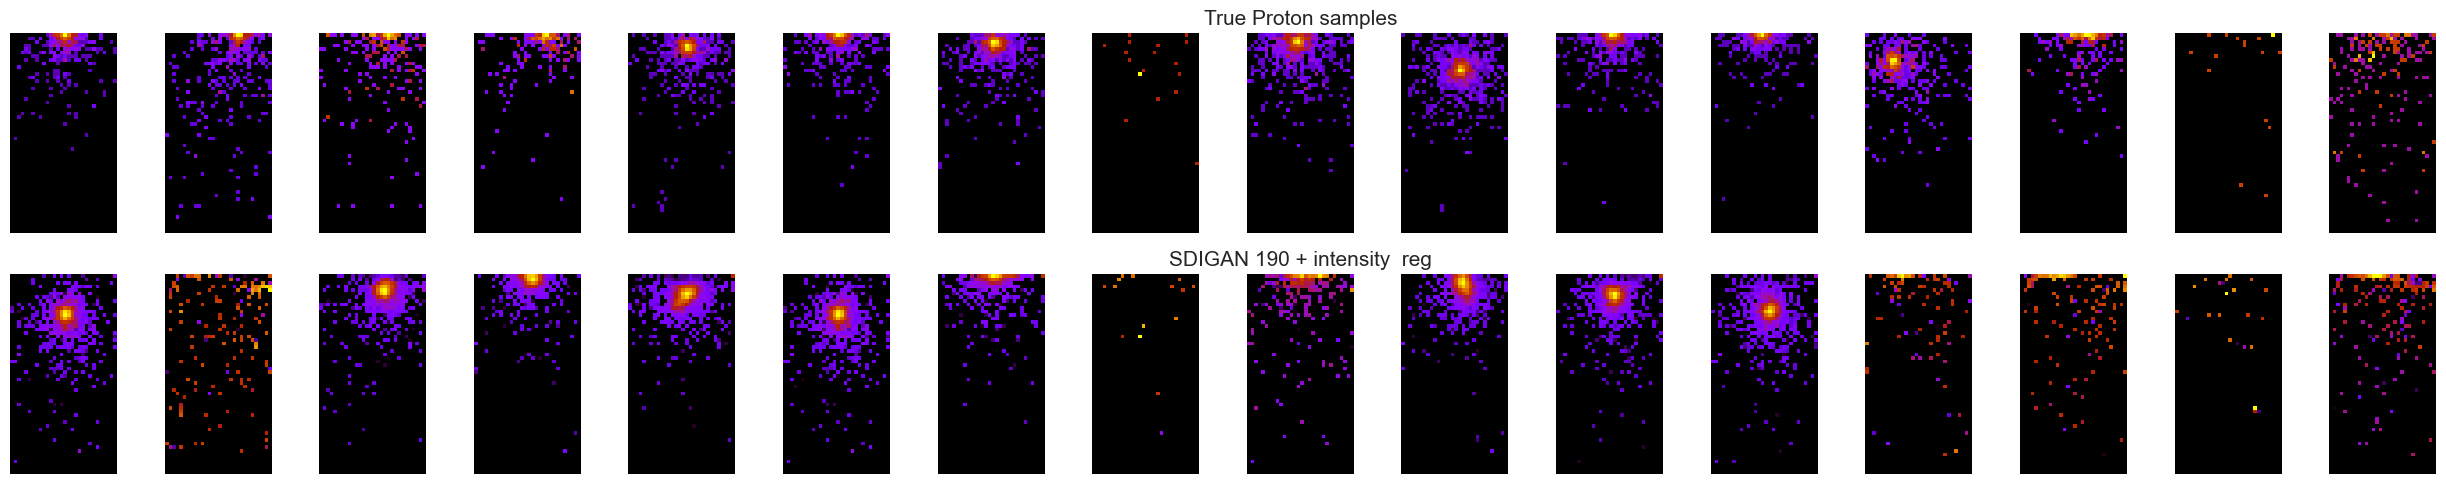

In [174]:
# for h in range(1101, 1201):
SAMPLES_IDXs = [1001, 4006, 1010, 4015, 1015, 4028, 91, 136, 3136, 171, 1171,  1253, 2276, 2378, 378, 3528]
SAMPLES_IDXs = [int(x) for x in SAMPLES_IDXs]
num_examples_to_generate = len(SAMPLES_IDXs)
noise_dim = 10

for i in range(0, 1):
    print(i)
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    seed_cond = y_test[SAMPLES_IDXs]
    generate_and_save_images_sdigan([seed, seed_cond], SAMPLES_IDXs)

## Calculate time of generation

In [61]:
import timeit
N_OF_EXPERIMENTS_TO_GENERATE = 10

In [64]:
print("Number of samples for each experiment: {}".format(len(y_test)))

Number of samples for each experiment: 68846
Number of samples for each experiment: 68846


In [63]:
from tabulate import tabulate

def plot_statistics(time_results):
    """
    Plots statistics of running execution time for experimets.
    :param time_resutls: List of execution time of each experiment.
    """
    stats_table = [
        ["Min: ", min(time_results)],
        ["Max: ", max(time_results)],
        ["Mean: ", np.mean(time_results)],
        ["Stddev: ", np.std(time_results)],
    ]
    table = tabulate(stats_table, tablefmt="github")
    table_title = "Execution time of experiment"
    full_table = f"{table_title}\n\n{table}"
    print(full_table)

### Measure execution times

In [65]:
n_generations = 200

In [68]:
#
# SDIN-GAN 286
#
def generate_test_sdigan():
    num_examples_to_generate, noise_dim = n_generations, 10
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    output = sdigan.predict([seed, y_test[:n_generations]])

In [69]:
execution_time_sdingan_286 = timeit.repeat(generate_test_sdigan, repeat=N_OF_EXPERIMENTS_TO_GENERATE, number=1)
plot_statistics(execution_time_sdingan_286)

4/7 [================>.............] - ETA: 0s

KeyboardInterrupt: 

## Histogram plots

In [181]:
def get_channels_dist_from_proton_model(generator, z, z_c, scale):
    results = generator.predict([z, z_c])
    results = np.exp(results)-1
    results = results*scale

    ch_gen = np.array(results).reshape(-1, 56, 30)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    return ch_gen

305/305 [==============================] - 9s 29ms/step


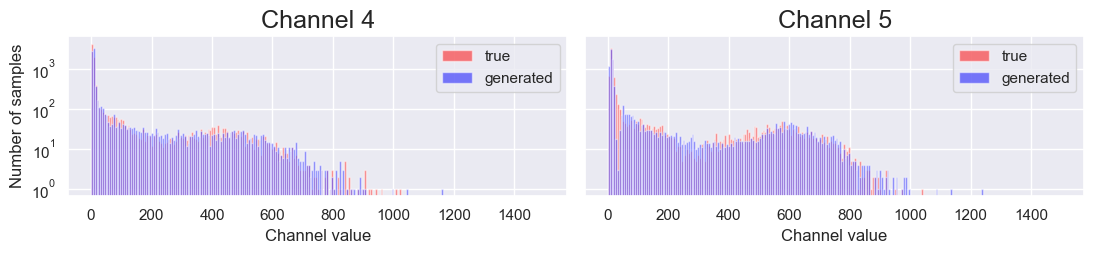

In [191]:
# def make_histograms_of_channels(scale=1, noise_std=1, noise_dim=10):
scale=1
noise_std=1
noise_dim=10
z = np.random.normal(0, noise_std, (x_test.shape[0], noise_dim))
z_c = y_test

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
models_dist_sdingan_190 = get_channels_dist_from_proton_model(sdingan_190, z, z_c, scale)

fig, axis = plt.subplots(1, 2, figsize=(12, 3), sharex=False, sharey=True)

axis[0].set_title('Channel 4', fontsize=18)
axis[1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for i, model_data in enumerate([models_dist_sdingan_190]): #[models_dist_vae, models_dist_gan, models_dist_sdigan, models_dist_sdingan]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[j].hist(ch_org[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[j].legend(loc='upper right')
        if j == 0:
            axis[j].set_ylabel('Number of samples')
        axis[j].set_xlabel('Channel value')
        axis[j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

# row_titles = ['SDI-GAN 190']#['VAE', 'GAN', 'SDI-GAN', 'SDI-GAN\n+ photonsum\nregularization']
# for ax, row in zip(axis[0], row_titles):
#     # Use the y-position of the axis and add a text to the figure
#     fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
#              va='center', ha='right', rotation='horizontal', fontsize=16)


fig.savefig("Thesis images/histograms_4_5_channels_sdigans_15_min.png")
plt.show()

# Compare performance across different levels of photon sums

1. How the SDI-GAN + reg trained on min photon sum 1 performs in comparison to these trained with 5 and 15 min photons:
 - ws distance
 - example sample plots
 - histogram plots




## Min photon 1 vs 5

In [ ]:
sdingan_1 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\unfiltered proton data\\gen_sin-gan_70.h5",
    compile=False)

In [213]:
data_cond = pd.read_pickle('../data/data_cond_photonsum_proton_5_2312.pkl')
data = pd.read_pickle('../data/data_photonsum_proton_5_2312.pkl')

In [214]:
proton_photon_sum = data_cond['proton_photon_sum']
std_proton = data_cond['std_proton']

In [215]:
data_cond.drop(columns=['proton_photon_sum', 'std_proton'], inplace=True)

In [216]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge
0,1304.340,-0.000018,0.000016,0.050293,-0.509192,0.461106,1304.340,0.000000,0.0
1,325.158,0.000000,0.000000,0.000000,0.269915,-0.081921,325.157,139.570610,-1.0
2,3192.380,0.000000,0.000000,0.000000,0.022422,-0.182957,-3192.380,939.565413,0.0
3,2082.630,0.000000,0.000000,0.000000,-0.171176,0.281748,2082.630,938.272081,1.0
4,174.401,0.000005,0.000002,-0.002588,0.292035,0.104749,-174.400,0.000000,0.0


#### Preprocess data

In [217]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data max 6.641182 min 0.0


In [218]:
scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

cond max 20.755913 min -19.050192


In [219]:
data_cond.mean(), data_cond.std(), std_proton.min(), std_proton.max()

(2.3328357e-09, 0.9999999, 0.0, 1.0)

In [220]:
_, x_test, _, y_test, _, std_test = train_test_split(data, data_cond, std_proton, test_size=0.2, shuffle=False)
print(x_test.shape, y_test.shape, std_test.shape)

(37220, 56, 30) (37220, 9) (37220,)


### WS

In [221]:
calculate_ws_ch(sdingan_1,
                x_test, y_test,
                ch_org, (-1, 56, 30))

1164/1164 [==============================] - 34s 29ms/step

 ------------------------------ 

ws mean 23.11 ch1 3.45 ch2 1.42 ch3 13.98 ch4 43.96 ch5 52.74 

1164/1164 [==============================] - 34s 29ms/step


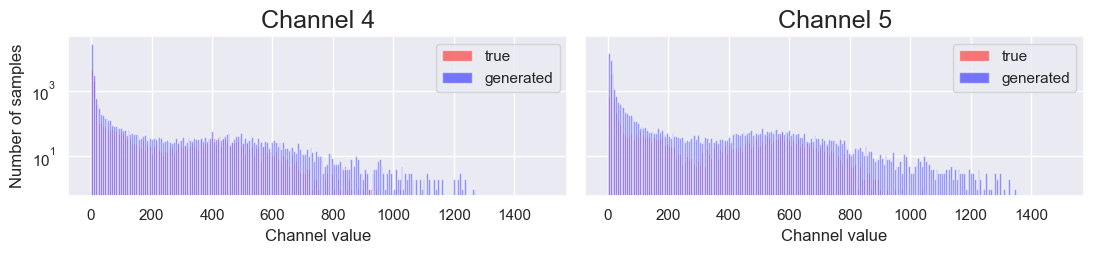

In [222]:
scale=1
noise_std=1
noise_dim=10
z = np.random.normal(0, noise_std, (x_test.shape[0], noise_dim))
z_c = y_test

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
models_dist_sdingan_1 = get_channels_dist_from_proton_model(sdingan_1, z, z_c, scale)

fig, axis = plt.subplots(1, 2, figsize=(12, 3), sharex=False, sharey=True)

axis[0].set_title('Channel 4', fontsize=18)
axis[1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for i, model_data in enumerate([models_dist_sdingan_1]): #[models_dist_vae, models_dist_gan, models_dist_sdigan, models_dist_sdingan]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[j].hist(ch_org[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[j].legend(loc='upper right')
        if j == 0:
            axis[j].set_ylabel('Number of samples')
        axis[j].set_xlabel('Channel value')
        axis[j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

# row_titles = ['SDI-GAN 190']#['VAE', 'GAN', 'SDI-GAN', 'SDI-GAN\n+ photonsum\nregularization']
# for ax, row in zip(axis[0], row_titles):
#     # Use the y-position of the axis and add a text to the figure
#     fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
#              va='center', ha='right', rotation='horizontal', fontsize=16)


fig.savefig("Thesis images/histograms_4_5_channels_sdigan_1_vs_5.png")
plt.show()

## Min 1 vs 15

In [202]:
data_cond = pd.read_pickle('../data/data_cond_stddev_photonsum_p_15_2133_n_15_3273.pkl')
data = pd.read_pickle('../data/data_proton_photonsum_proton_15_2133_neutron_15_3273.pkl')

In [203]:
proton_photon_sum = data_cond['proton_photon_sum']
std_proton = data_cond['std_proton']

In [204]:
data_cond.drop(columns=['proton_photon_sum', 'std_proton', 'group_number_proton', 'neutron_photon_sum', 'std_neutron', 'group_number_neutron'], inplace=True)

In [205]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge
0,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0
1,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0
2,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0
3,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0
4,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0


#### Preprocess data

In [206]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data max 6.5206213 min 0.0


In [207]:
scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

cond max 21.432093 min -35.632454


In [208]:
data_cond.mean(), data_cond.std(), std_proton.min(), std_proton.max()

(-3.5499639e-09, 0.99999994, 0.0, 1.0)

In [209]:
_, x_test, _, y_test, _, std_test = train_test_split(data, data_cond, std_proton, test_size=0.2, shuffle=False)
print(x_test.shape, y_test.shape, std_test.shape, group_test.shape)

(9743, 56, 30) (9743, 9) (9743,) (68846,)


### WS

In [210]:
calculate_ws_ch(sdingan_1,
                x_test, y_test,
                ch_org, (-1, 56, 30))

305/305 [==============================] - 9s 29ms/step

 ------------------------------ 

ws mean 13.87 ch1 4.43 ch2 0.51 ch3 13.23 ch4 27.58 ch5 23.62 

305/305 [==============================] - 9s 29ms/step


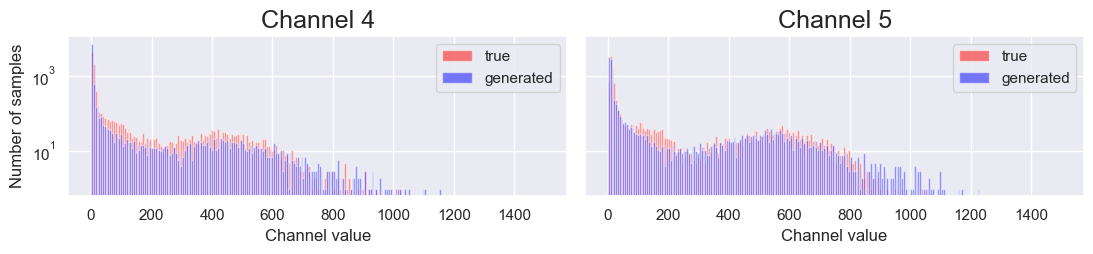

In [212]:
scale=1
noise_std=1
noise_dim=10
z = np.random.normal(0, noise_std, (x_test.shape[0], noise_dim))
z_c = y_test

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
models_dist_sdingan_1 = get_channels_dist_from_proton_model(sdingan_1, z, z_c, scale)

fig, axis = plt.subplots(1, 2, figsize=(12, 3), sharex=False, sharey=True)

axis[0].set_title('Channel 4', fontsize=18)
axis[1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for i, model_data in enumerate([models_dist_sdingan_1]): #[models_dist_vae, models_dist_gan, models_dist_sdigan, models_dist_sdingan]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[j].hist(ch_org[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[j].legend(loc='upper right')
        if j == 0:
            axis[j].set_ylabel('Number of samples')
        axis[j].set_xlabel('Channel value')
        axis[j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

# row_titles = ['SDI-GAN 190']#['VAE', 'GAN', 'SDI-GAN', 'SDI-GAN\n+ photonsum\nregularization']
# for ax, row in zip(axis[0], row_titles):
#     # Use the y-position of the axis and add a text to the figure
#     fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
#              va='center', ha='right', rotation='horizontal', fontsize=16)


fig.savefig("Thesis images/histograms_4_5_channels_sdigan_1_vs_15.png")
plt.show()

# Show diversity plots for groups at different filtering level

# Min 18 sumphotons proton data

In [71]:
data_cond = pd.read_pickle('../data/data_cond_photonsum_proton_18_2312.pkl')
data = pd.read_pickle('../data/data_photonsum_proton_18_2312.pkl')

In [72]:
proton_photon_sum = data_cond['proton_photon_sum']
std_proton = data_cond['std']

In [73]:
data_cond.drop(columns=['proton_photon_sum', 'std'], inplace=True)

In [74]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge
0,3961.5500,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.5500,938.272081,1.0
1,2770.1000,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.1000,497.611000,0.0
2,2778.4000,0.000000e+00,0.000000e+00,0.000000e+00,-0.102053,0.152853,2778.4000,938.272081,1.0
3,41.3421,0.000000e+00,0.000000e+00,0.000000e+00,0.075039,0.000853,41.3314,939.565413,0.0
4,3195.1200,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.1100,938.272081,1.0


#### Preprocess data

In [75]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data max 6.641182 min 0.0


In [76]:
scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

cond max 32.011635 min -29.51756


In [77]:
data_cond.mean(), data_cond.std(), std_proton.min(), std_proton.max()

(3.1246195e-10, 1.0, 0.0, 1.0)

In [78]:
_, x_test, _, y_test, std_train, std_test = train_test_split(data, data_cond, std_proton, test_size=0.2, shuffle=False)
print(x_test.shape, y_test.shape, std_test.shape, std_train.shape)

(17296, 56, 30) (17296, 9) (17296,) (69181,)


## Load models

In [156]:
sdingan_190 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\min_15_proton\\gen_sin-gan_190.h5",
    compile=False)

### Function for calculating sum of channels

### Calculate channels for original simulation test data

In [157]:
org = np.exp(x_test)-1
ch_org = np.array(org).reshape(-1, 56, 30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values

In [158]:
org.shape
del org

### Define functions for calculating WS

In [159]:
def calculate_ws_ch(generator,
                    x_test, y_test,
                    ch_org, data_shape,
                    n_calc=5,
                    scale=1, noise_std=1):
    """
    Calculates ws distance for each channel separately.
    """
    ws = [0, 0, 0, 0, 0]
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (x_test.shape[0], 10))
        z_c = y_test
        results = generator.predict([z, z_c])
        results = np.exp(results) - 1
        results = results * scale

        ch_gen = np.array(results).reshape(data_shape)
        ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
        for i in range(5):
            ws[i] = ws[i] + wasserstein_distance(ch_org[:, i], ch_gen[:, i])
        ws = np.array(ws)

    ws = ws / n_calc
    print("\n", "-" * 30, "\n")
    print("ws mean", f'{ws.sum() / 5:.2f}', end=" ")
    for n, score in enumerate(ws):
        print("ch" + str(n + 1), f'{score:.2f}', end=" ")

## Calculate ws

In [160]:
# SDI-GAN
calculate_ws_ch(sdingan_190,
                x_test, y_test,
                ch_org, (-1, 56, 30))

305/305 [==============================] - 8s 28ms/step

 ------------------------------ 

ws mean 2.92 ch1 0.45 ch2 0.64 ch3 3.47 ch4 3.94 ch5 6.12 

## Test models diversity

1. generate 5 samples for every conditional data and calculate std within this groups

In [161]:
from sklearn.metrics import mean_absolute_error

In [162]:
def model_diversity(generator,
                    y_test, std_test,
                    n_calc=10,
                    noise_std=1):
    """
    Performs n_calculations for the same x_test, y_test data and saves images to list.
    """
    n_samples = y_test.shape[0]
    images_data = np.ndarray(shape=(n_samples, 1680, n_calc))
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (n_samples, 10))
        z_c = y_test
        results = generator.predict([z, z_c])
        results = np.exp(results) - 1

        # 1. flatten responses
        flatten_responses = results.reshape(len(results), -1)  # (n_samples, 1680)
        flatten_responses = flatten_responses.reshape(n_samples, -1, 1)
        images_data = np.append(images_data, flatten_responses, axis=2)

    return mean_absolute_error(np.std(images_data, axis=2).sum(axis=1), std_test.values)
    #
    #     ch_gen = np.array(results).reshape(data_shape)
    #     ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    #     for i in range(5):
    #         ws[i] = ws[i] + wasserstein_distance(ch_org[:, i], ch_gen[:, i])
    #     ws = np.array(ws)
    #
    # ws = ws / n_calc
    # print("\n", "-" * 30, "\n")
    # print("ws mean", f'{ws.sum() / 5:.2f}', end=" ")
    # for n, score in enumerate(ws):
    #     print("ch" + str(n + 1), f'{score:.2f}', end=" ")

In [163]:
diversity_loss = model_diversity(sdingan_190, y_test, std_test, n_calc=10)
diversity_loss

305/305 [==============================] - 9s 31ms/step


217.4160585384307

Plot distribution of number of photons

## Plot samples

In [164]:
def searching_for_good_looking_respones(SAMPLES_IDXs):

    fig, axs = plt.subplots(1, 5, figsize=(9, 3))

    for i in range(0, 5):
        # Real Neutron
        title_model = "True Proton samples"
        x = x_test[SAMPLES_IDXs][i % 5].reshape(56, 30)

        axs[2].set_title(f"{SAMPLES_IDXs}", fontsize=15)
        im = axs[i].imshow(x, cmap='gnuplot')
        axs[i % 5].axis('off')

    plt.tight_layout()
    plt.savefig(f"Thesis images/good_proton_responses_15_min/{'_'.join([str(x) for x in SAMPLES_IDXs])}.png", dpi=60)
    plt.close()

IndexError: index 9778 is out of bounds for axis 0 with size 9743

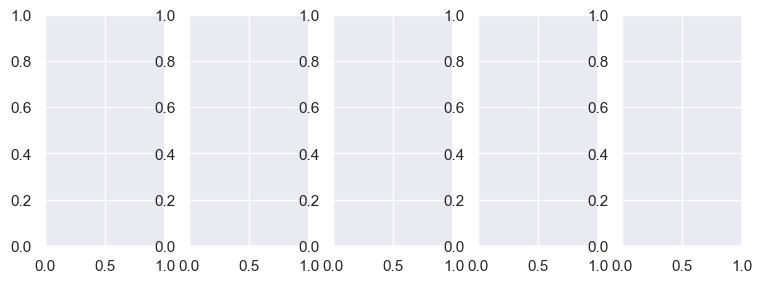

In [166]:
SAMPLES_IDXs = [0, 1000, 2000, 3000, 4000] # 1316, 41526, 2315

for i in range(0, 1000):
    SAMPLES_IDXs = [x+i for x in SAMPLES_IDXs]
    searching_for_good_looking_respones(SAMPLES_IDXs)

1001, 4006, 1010, 4015, 1015, 4028, 91, 136, 3136, 171, 1171,  1253, 2276, 2378, 378, 3528

In [172]:
def generate_and_save_images_sdigan(test_input, SAMPLES_IDXs):
    # produce predictions
    predictions_sdingan_190 = sdingan_190(test_input, training=False)

    fig, axs = plt.subplots(2, len(SAMPLES_IDXs), figsize=(25, 5))
    # plt.title(SAMPLES_IDXs, x=0.1, horizontalalignment='left')
    im_in_row = []
    for i in range(0, len(SAMPLES_IDXs)*2):
        if i < len(SAMPLES_IDXs):
            # Real Neutron
            title_model = "True Proton samples"
            row = 0
            x = x_test[SAMPLES_IDXs][i % len(SAMPLES_IDXs)].reshape(56, 30)
        elif i >= len(SAMPLES_IDXs) and i < 2*len(SAMPLES_IDXs):
            # VAE model
            title_model = "SDIGAN 190 + intensity  reg"
            row = 1
            x = predictions_sdingan_190[i % len(SAMPLES_IDXs)].numpy().reshape(56, 30)

        axs[row, len(SAMPLES_IDXs)//2].set_title(title_model, fontsize=15)
        im = axs[row, i % len(SAMPLES_IDXs)].imshow(x, cmap='gnuplot')
        axs[row, i % len(SAMPLES_IDXs)].axis('off')
        im_in_row.append(im)

    plt.tight_layout()
    plt.savefig(f"Thesis images/15_min_photonsum{'_'.join([str(x) for x in SAMPLES_IDXs])}.png", dpi=300)
    # plt.close()

0


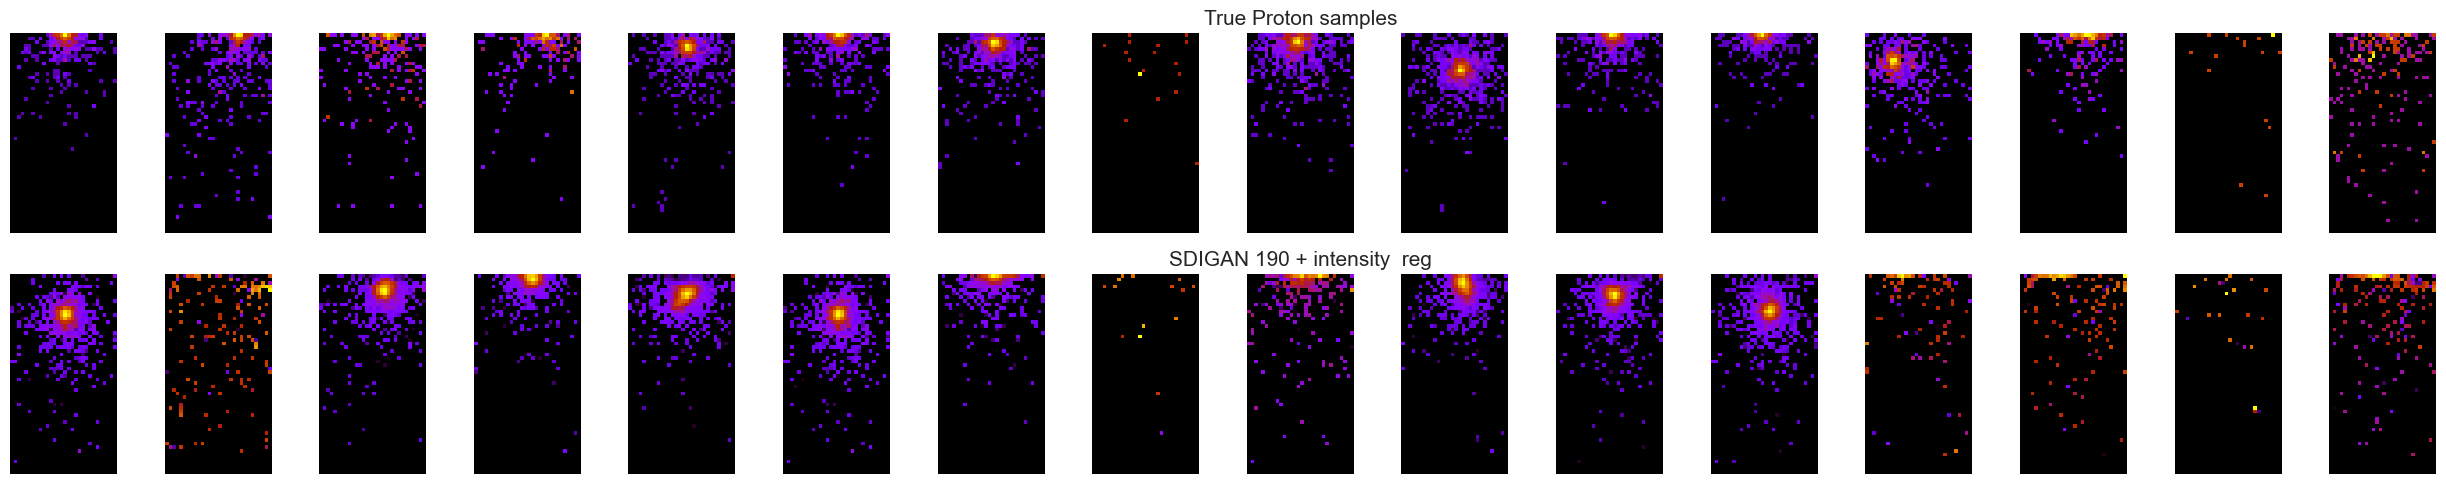

In [174]:
# for h in range(1101, 1201):
SAMPLES_IDXs = [1001, 4006, 1010, 4015, 1015, 4028, 91, 136, 3136, 171, 1171,  1253, 2276, 2378, 378, 3528]
SAMPLES_IDXs = [int(x) for x in SAMPLES_IDXs]
num_examples_to_generate = len(SAMPLES_IDXs)
noise_dim = 10

for i in range(0, 1):
    print(i)
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    seed_cond = y_test[SAMPLES_IDXs]
    generate_and_save_images_sdigan([seed, seed_cond], SAMPLES_IDXs)

## Calculate time of generation

In [61]:
import timeit
N_OF_EXPERIMENTS_TO_GENERATE = 10

In [64]:
print("Number of samples for each experiment: {}".format(len(y_test)))

Number of samples for each experiment: 68846
Number of samples for each experiment: 68846


In [63]:
from tabulate import tabulate

def plot_statistics(time_results):
    """
    Plots statistics of running execution time for experimets.
    :param time_resutls: List of execution time of each experiment.
    """
    stats_table = [
        ["Min: ", min(time_results)],
        ["Max: ", max(time_results)],
        ["Mean: ", np.mean(time_results)],
        ["Stddev: ", np.std(time_results)],
    ]
    table = tabulate(stats_table, tablefmt="github")
    table_title = "Execution time of experiment"
    full_table = f"{table_title}\n\n{table}"
    print(full_table)

### Measure execution times

In [65]:
n_generations = 200

In [68]:
#
# SDIN-GAN 286
#
def generate_test_sdigan():
    num_examples_to_generate, noise_dim = n_generations, 10
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    output = sdigan.predict([seed, y_test[:n_generations]])

In [69]:
execution_time_sdingan_286 = timeit.repeat(generate_test_sdigan, repeat=N_OF_EXPERIMENTS_TO_GENERATE, number=1)
plot_statistics(execution_time_sdingan_286)

4/7 [================>.............] - ETA: 0s

KeyboardInterrupt: 

## Histogram plots

In [181]:
def get_channels_dist_from_proton_model(generator, z, z_c, scale):
    results = generator.predict([z, z_c])
    results = np.exp(results)-1
    results = results*scale

    ch_gen = np.array(results).reshape(-1, 56, 30)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    return ch_gen

305/305 [==============================] - 9s 29ms/step


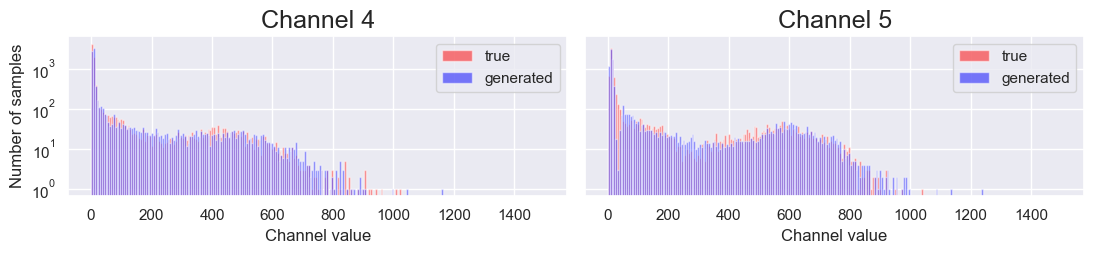

In [191]:
# def make_histograms_of_channels(scale=1, noise_std=1, noise_dim=10):
scale=1
noise_std=1
noise_dim=10
z = np.random.normal(0, noise_std, (x_test.shape[0], noise_dim))
z_c = y_test

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
models_dist_sdingan_190 = get_channels_dist_from_proton_model(sdingan_190, z, z_c, scale)

fig, axis = plt.subplots(1, 2, figsize=(12, 3), sharex=False, sharey=True)

axis[0].set_title('Channel 4', fontsize=18)
axis[1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for i, model_data in enumerate([models_dist_sdingan_190]): #[models_dist_vae, models_dist_gan, models_dist_sdigan, models_dist_sdingan]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[j].hist(ch_org[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[j].legend(loc='upper right')
        if j == 0:
            axis[j].set_ylabel('Number of samples')
        axis[j].set_xlabel('Channel value')
        axis[j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

# row_titles = ['SDI-GAN 190']#['VAE', 'GAN', 'SDI-GAN', 'SDI-GAN\n+ photonsum\nregularization']
# for ax, row in zip(axis[0], row_titles):
#     # Use the y-position of the axis and add a text to the figure
#     fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
#              va='center', ha='right', rotation='horizontal', fontsize=16)


fig.savefig("Thesis images/histograms_4_5_channels_sdigans_15_min.png")
plt.show()

# Compare performance across different levels of photon sums

1. How the SDI-GAN + reg trained on min photon sum 1 performs in comparison to these trained with 5 and 15 min photons:
 - ws distance
 - example sample plots
 - histogram plots




## Min photon 1 vs 5

In [ ]:
sdingan_1 = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\unfiltered proton data\\gen_sin-gan_70.h5",
    compile=False)

In [213]:
data_cond = pd.read_pickle('../data/data_cond_photonsum_proton_5_2312.pkl')
data = pd.read_pickle('../data/data_photonsum_proton_5_2312.pkl')

In [214]:
proton_photon_sum = data_cond['proton_photon_sum']
std_proton = data_cond['std_proton']

In [215]:
data_cond.drop(columns=['proton_photon_sum', 'std_proton'], inplace=True)

In [216]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge
0,1304.340,-0.000018,0.000016,0.050293,-0.509192,0.461106,1304.340,0.000000,0.0
1,325.158,0.000000,0.000000,0.000000,0.269915,-0.081921,325.157,139.570610,-1.0
2,3192.380,0.000000,0.000000,0.000000,0.022422,-0.182957,-3192.380,939.565413,0.0
3,2082.630,0.000000,0.000000,0.000000,-0.171176,0.281748,2082.630,938.272081,1.0
4,174.401,0.000005,0.000002,-0.002588,0.292035,0.104749,-174.400,0.000000,0.0


#### Preprocess data

In [217]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data max 6.641182 min 0.0


In [218]:
scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

cond max 20.755913 min -19.050192


In [219]:
data_cond.mean(), data_cond.std(), std_proton.min(), std_proton.max()

(2.3328357e-09, 0.9999999, 0.0, 1.0)

In [220]:
_, x_test, _, y_test, _, std_test = train_test_split(data, data_cond, std_proton, test_size=0.2, shuffle=False)
print(x_test.shape, y_test.shape, std_test.shape)

(37220, 56, 30) (37220, 9) (37220,)


### WS

In [221]:
calculate_ws_ch(sdingan_1,
                x_test, y_test,
                ch_org, (-1, 56, 30))

1164/1164 [==============================] - 34s 29ms/step

 ------------------------------ 

ws mean 23.11 ch1 3.45 ch2 1.42 ch3 13.98 ch4 43.96 ch5 52.74 

1164/1164 [==============================] - 34s 29ms/step


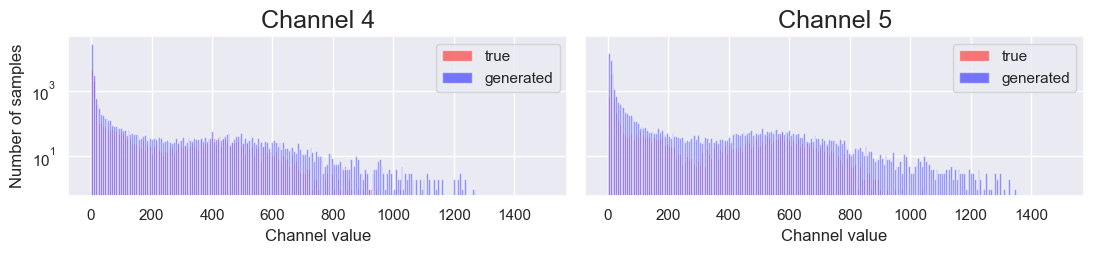

In [222]:
scale=1
noise_std=1
noise_dim=10
z = np.random.normal(0, noise_std, (x_test.shape[0], noise_dim))
z_c = y_test

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
models_dist_sdingan_1 = get_channels_dist_from_proton_model(sdingan_1, z, z_c, scale)

fig, axis = plt.subplots(1, 2, figsize=(12, 3), sharex=False, sharey=True)

axis[0].set_title('Channel 4', fontsize=18)
axis[1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for i, model_data in enumerate([models_dist_sdingan_1]): #[models_dist_vae, models_dist_gan, models_dist_sdigan, models_dist_sdingan]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[j].hist(ch_org[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[j].legend(loc='upper right')
        if j == 0:
            axis[j].set_ylabel('Number of samples')
        axis[j].set_xlabel('Channel value')
        axis[j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

# row_titles = ['SDI-GAN 190']#['VAE', 'GAN', 'SDI-GAN', 'SDI-GAN\n+ photonsum\nregularization']
# for ax, row in zip(axis[0], row_titles):
#     # Use the y-position of the axis and add a text to the figure
#     fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
#              va='center', ha='right', rotation='horizontal', fontsize=16)


fig.savefig("Thesis images/histograms_4_5_channels_sdigan_1_vs_5.png")
plt.show()

## Min 1 vs 15

In [202]:
data_cond = pd.read_pickle('../data/data_cond_stddev_photonsum_p_15_2133_n_15_3273.pkl')
data = pd.read_pickle('../data/data_proton_photonsum_proton_15_2133_neutron_15_3273.pkl')

In [203]:
proton_photon_sum = data_cond['proton_photon_sum']
std_proton = data_cond['std_proton']

In [204]:
data_cond.drop(columns=['proton_photon_sum', 'std_proton', 'group_number_proton', 'neutron_photon_sum', 'std_neutron', 'group_number_neutron'], inplace=True)

In [205]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge
0,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0
1,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0
2,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0
3,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0
4,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0


#### Preprocess data

In [206]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data max 6.5206213 min 0.0


In [207]:
scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

cond max 21.432093 min -35.632454


In [208]:
data_cond.mean(), data_cond.std(), std_proton.min(), std_proton.max()

(-3.5499639e-09, 0.99999994, 0.0, 1.0)

In [209]:
_, x_test, _, y_test, _, std_test = train_test_split(data, data_cond, std_proton, test_size=0.2, shuffle=False)
print(x_test.shape, y_test.shape, std_test.shape, group_test.shape)

(9743, 56, 30) (9743, 9) (9743,) (68846,)


### WS

In [210]:
calculate_ws_ch(sdingan_1,
                x_test, y_test,
                ch_org, (-1, 56, 30))

305/305 [==============================] - 9s 29ms/step

 ------------------------------ 

ws mean 13.87 ch1 4.43 ch2 0.51 ch3 13.23 ch4 27.58 ch5 23.62 

305/305 [==============================] - 9s 29ms/step


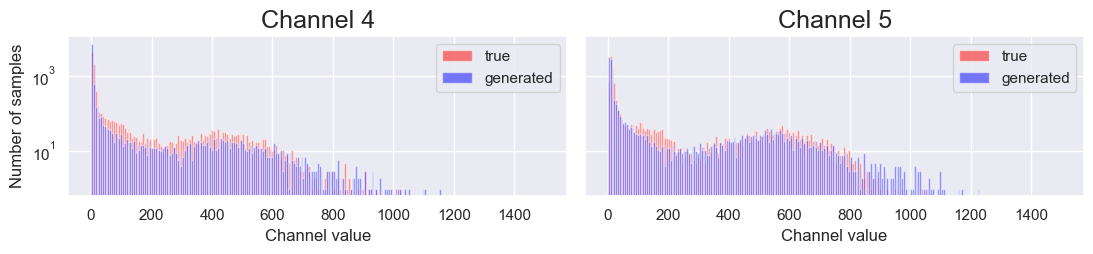

In [212]:
scale=1
noise_std=1
noise_dim=10
z = np.random.normal(0, noise_std, (x_test.shape[0], noise_dim))
z_c = y_test

# get results from all models
channels_to_get = [3, 4]  # get channels 4 and 5
models_dist_sdingan_1 = get_channels_dist_from_proton_model(sdingan_1, z, z_c, scale)

fig, axis = plt.subplots(1, 2, figsize=(12, 3), sharex=False, sharey=True)

axis[0].set_title('Channel 4', fontsize=18)
axis[1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for i, model_data in enumerate([models_dist_sdingan_1]): #[models_dist_vae, models_dist_gan, models_dist_sdigan, models_dist_sdingan]):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[j].hist(ch_org[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[j].legend(loc='upper right')
        if j == 0:
            axis[j].set_ylabel('Number of samples')
        axis[j].set_xlabel('Channel value')
        axis[j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

# row_titles = ['SDI-GAN 190']#['VAE', 'GAN', 'SDI-GAN', 'SDI-GAN\n+ photonsum\nregularization']
# for ax, row in zip(axis[0], row_titles):
#     # Use the y-position of the axis and add a text to the figure
#     fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
#              va='center', ha='right', rotation='horizontal', fontsize=16)


fig.savefig("Thesis images/histograms_4_5_channels_sdigan_1_vs_15.png")
plt.show()

# Joined model

Min 18 sumphotons proton data

In [3]:
# data = pd.read_pickle('../data/data_proton_neutron_photonsum_proton_18_1970_neutron_18_3249_padding.pkl')
# data_cond = pd.read_pickle('../data/data_cond_photonsum_proton_18_neutron_18.pkl')
data = pd.read_pickle('../data/data_proton_neutron_photonsum_proton_18_1970_neutron_18_3249_padding.pkl')
data_cond = pd.read_pickle('../data/data_cond_stddev_photonsum_p_18_n_18.pkl')

In [4]:
proton_photon_sum = data_cond['proton_photon_sum']
std_proton = data_cond['std_proton']

In [5]:
data_cond.drop(columns=['proton_photon_sum', 'std_proton', 'neutron_photon_sum', 'std_neutron'], inplace=True)

In [6]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge
0,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0
1,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0
2,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0
3,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0
4,1948.29,1.323670e-08,5.575600e-09,-5.280860e-05,0.470391,0.154206,-1948.29,0.000000,0.0


#### Preprocess data

In [7]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

data max 6.403574 min 0.0


In [8]:
scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

cond max 29.744112 min -59.095673


In [9]:
_, x_test, _, y_test, _, std_test = train_test_split(data, data_cond, std_proton, test_size=0.2, shuffle=False)
print(x_test.shape, y_test.shape, std_test.shape)

(7670, 56, 44, 2) (7670, 9) (7670,)


In [10]:
x_test_p, x_test_n = x_test[:,:,:,0], x_test[:,:,:,1]

## Load models

In [11]:
joint = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\joint"
    "\\gen_sin-gan-join-aux-reg-arch-2_481.h5",
    compile=False)
model_proton = tf.keras.models.load_model(
    "C:\\Users\\PB\\Documents\\GithubRepos\\Generative-Models-for-CERN-Fast-Simulations\\notebooks\\best models\\18_proton\\gen_sin-gan-aux-reg-arch-2_105.h5",
    compile=False)

### Function for calculating sum of channels

### Calculate channels for original simulation test data

In [12]:
org_p = np.exp(x_test_p)-1
ch_org_p = np.array(org_p).reshape(-1, 56, 44)
ch_org_p = pd.DataFrame(sum_channels_parallel(ch_org_p)).values

org_n = np.exp(x_test_n)-1
ch_org_n = np.array(org_n).reshape(-1, 56, 44)
ch_org_n = pd.DataFrame(sum_channels_parallel(ch_org_n)).values

NameError: name 'sum_channels_parallel' is not defined

In [ ]:
del org_p, org_n

### Define functions for calculating WS

In [ ]:
def calculate_ws_ch_joint(generator,
                          x_test, y_test,
                          n_calc=5,
                          scale=1, noise_std=1):
    """
    Calculates ws distance for each channel separately.
    """
    ws_p = [0, 0, 0, 0, 0]
    ws_n = [0, 0, 0, 0, 0]
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (x_test.shape[0], 10))
        z_c = y_test

        results = generator.predict([z, z_c])

        results_p, results_n = results[:,:,:,0], results[:,:,:,1]

        results_p = np.exp(results_p) - 1
        results_p = results_p * scale

        results_n = np.exp(results_n) - 1
        results_n = results_n * scale

        ch_gen_p = np.array(results_p).reshape((-1, 56, 44))
        ch_gen_p = pd.DataFrame(sum_channels_parallel(ch_gen_p)).values

        ch_gen_n = np.array(results_n).reshape((-1, 56, 44))
        ch_gen_n = pd.DataFrame(sum_channels_parallel(ch_gen_n)).values
        for i in range(5):
            ws_p[i] = ws_p[i] + wasserstein_distance(ch_org_p[:, i], ch_gen_p[:, i])
            ws_n[i] = ws_n[i] + wasserstein_distance(ch_org_n[:, i], ch_gen_n[:, i])
        ws_p = np.array(ws_p)
        ws_n = np.array(ws_n)
    _get_ws(ws_p, n_calc=n_calc, data_type="Proton data")
    _get_ws(ws_n, n_calc=n_calc, data_type="Neutron data")

def _get_ws(ws, n_calc, data_type):
    ws = ws / n_calc
    print(data_type)
    print("\n", "-" * 30, "\n")
    print("ws mean", f'{ws.sum() / 5:.4f}', end=" ")
    for n, score in enumerate(ws):
        print("ch" + str(n + 1), f'{score:.4f}', end=" ")

## Calculate ws

In [146]:
# SDI-GAN
calculate_ws_ch_joint(joint, x_test, y_test)

240/240 [==============================] - 7s 27ms/step
Proton data

 ------------------------------ 

ws mean 6.3220 ch1 0.2866 ch2 0.4112 ch3 9.2059 ch4 5.9759 ch5 15.7304 Neutron data

 ------------------------------ 

ws mean 6.8358 ch1 7.4533 ch2 8.7307 ch3 3.7597 ch4 3.3600 ch5 10.8755 

## Plot samples

1001, 4006, 1010, 4015, 1015, 4028, 91, 136, 3136, 171, 1171,  1253, 2276, 2378, 378, 3528

In [37]:
def generate_and_save_images_sdigan(test_input, SAMPLES_IDXs, h):
    # produce predictions
    predictions_joint = joint(test_input, training=False)
    predictions_proton = model_proton(test_input, training=False)

    predictions_joint_p = predictions_joint[:,:,:,0]

    fig, axs = plt.subplots(3, len(SAMPLES_IDXs), figsize=(16, 9), layout='compressed')
    im_in_row = []
    for i in range(0, len(SAMPLES_IDXs)*3):
        if i < len(SAMPLES_IDXs):
            # Real Neutron
            title_model = "True Proton Samples"
            row = 0
            x = x_test_p[SAMPLES_IDXs][i % len(SAMPLES_IDXs)].reshape(56, 44)
        elif i >= len(SAMPLES_IDXs) and i < 2*len(SAMPLES_IDXs):
            # joint proton
            title_model = "Joint Model Proton Channel"
            row = 1
            x = predictions_joint_p[i % len(SAMPLES_IDXs)].numpy().reshape(56, 44)
        else:
            # Proton
            title_model = "Proton Model"
            row = 2
            x = predictions_proton[i % len(SAMPLES_IDXs)].numpy().reshape(56, 30)

        axs[row, len(SAMPLES_IDXs)//2].set_title(title_model, fontsize=18)
        im = axs[row, i % len(SAMPLES_IDXs)].imshow(x, cmap='gnuplot')
        axs[row, i % len(SAMPLES_IDXs)].axis('off')
        im_in_row.append(im)

        # add colorbar to the last image, but scale is with respect to the all images in row
        if i % 8 == 7:
            fig.colorbar(im, ax=axs[i // 8, :])

    # plt.tight_layout(rect=[0.98, 0.98, 0.98, 0.2])
    plt.savefig(f"Thesis images/joint_separate_comparison_2/{'_'.join([str(x) for x in SAMPLES_IDXs])}_{h}.png", dpi=300)
    plt.close()

# for h in range(1101, 1201):
# 3561, 1653, 2211, 7403, 5950
# SAMPLES_IDXs = [1001, 1711, 1010, 91, 7403, 2276, 2378, 378, 3528] # , 4028, 91, 136, 3136, 171, 1171,  1253, 2276, 2378, 378, 3528
SAMPLES_IDXs = [6465, 5006, 6021, 6138, 7227, 5749, 6731, 6324, 7091]
# [1001, 1711, 1010, 3561, 7403, 4028, 5950, 136, 3136]
num_examples_to_generate = len(SAMPLES_IDXs)
noise_dim = 10

for i in range(80, 100):
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    seed_cond = y_test[SAMPLES_IDXs]
    generate_and_save_images_sdigan([seed, seed_cond], SAMPLES_IDXs, i)

In [ ]:
SAMPLES_IDXs = [8356, 5356, 8151, 5950, 5465, 5916, 5021, 6021, 7091, 5406, 5006, 5591, 6731, 6465, 7076, 6585, 5561, 6138, 7227, 5749, 6824, 6324, 5877]

In [23]:
def searching_for_good_looking_respones(SAMPLES_IDXs):
    fig, axs = plt.subplots(1, 5, figsize=(9, 3))

    for i in range(0, 5):
        # Real Neutron
        title_model = "True Proton Samples"
        x = x_test_p[SAMPLES_IDXs][i % 5].reshape(56, 44)

        axs[2].set_title(f"{SAMPLES_IDXs}", fontsize=17)
        im = axs[i].imshow(x, cmap='gnuplot')
        axs[i % 5].axis('off')

    plt.tight_layout()
    plt.savefig(f"Thesis images/looking_good_responses_18/{'_'.join([str(x) for x in SAMPLES_IDXs])}.png", dpi=60)
    plt.close()


for i in range(300, 400):
    SAMPLES_IDXs = [5000, 5500, 6000, 6500, 7000]
    SAMPLES_IDXs = [x + i for x in SAMPLES_IDXs]
    searching_for_good_looking_respones(SAMPLES_IDXs)

## Calculate time of generation

In [65]:
import timeit
N_OF_EXPERIMENTS_TO_GENERATE = 10

In [66]:
print("Number of samples for each experiment: {}".format(len(y_test)))

Number of samples for each experiment: 9743


In [67]:
from tabulate import tabulate

def plot_statistics(time_results):
    """
    Plots statistics of running execution time for experimets.
    :param time_resutls: List of execution time of each experiment.
    """
    stats_table[
        ["Min: ", min(time_results)],
        ["Max: ", max(time_results)],
        ["Mean: ", np.mean(time_results)],
        ["Stddev: ", np.std(time_results)],
    ] =
    table = tabulate(stats_table, tablefmt="github")
    table_title = "Execution time of experiment"
    full_table = f"{table_title}\n\n{table}"
    print(full_table)

### Measure execution times

In [79]:
n_generations = 1000

In [80]:
def generate_test_joint():
    num_examples_to_generate, noise_dim = n_generations, 10
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    output = joint.predict([seed, y_test[:n_generations]])

In [81]:
execution_time_joint = timeit.repeat(generate_test_joint, repeat=N_OF_EXPERIMENTS_TO_GENERATE, number=1)
plot_statistics(execution_time_joint)

32/32 [==============================] - 1s 25ms/step
Execution time of experiment

|---------|----------|
| Min:    | 0.909235 |
| Max:    | 1.18328  |
| Mean:   | 0.942106 |
| Stddev: | 0.080635 |


## Histogram plots

In [22]:
def get_channels_dist_from_joint_model(generator):
    z = np.random.normal(0, 1, (x_test.shape[0], 10))
    z_c = y_test

    results = generator.predict([z, z_c])

    results_p, results_n = results[:,:,:,0], results[:,:,:,1]

    results_p = np.exp(results_p) - 1
    results_p = results_p * 1

    results_n = np.exp(results_n) - 1
    results_n = results_n * 1

    ch_gen_p = np.array(results_p).reshape((-1, 56, 44))
    ch_gen_p = pd.DataFrame(sum_channels_parallel(ch_gen_p)).values

    ch_gen_n = np.array(results_n).reshape((-1, 56, 44))
    ch_gen_n = pd.DataFrame(sum_channels_parallel(ch_gen_n)).values
    return ch_gen_p, ch_gen_n

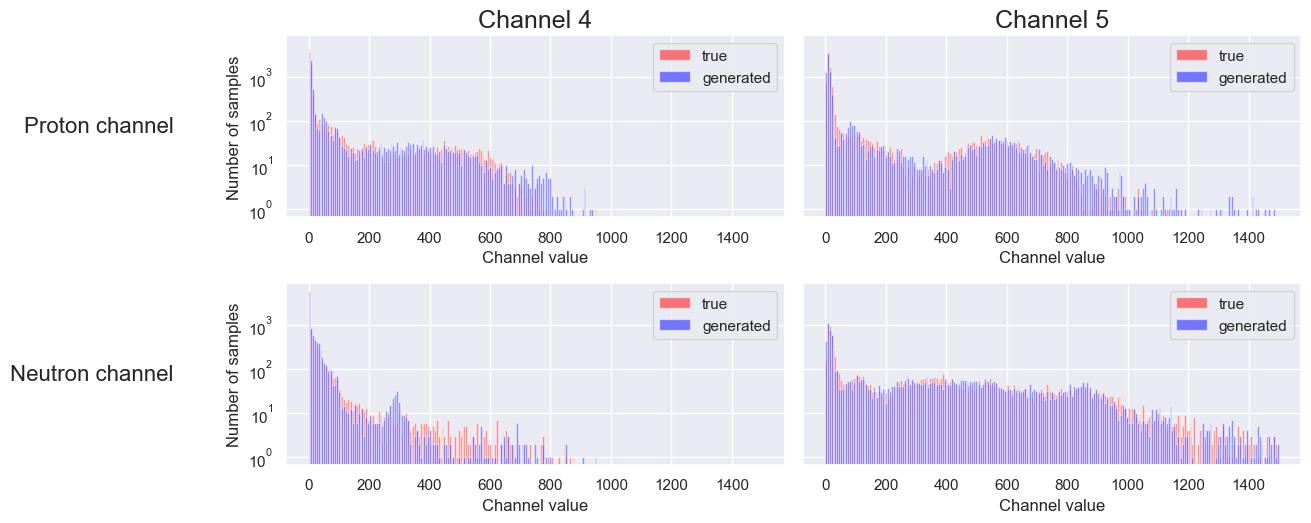

In [29]:
channels_to_get = [3, 4]  # get channels 4 and 5
# models_dist_joint_p, models_dist_joint_n = get_channels_dist_from_joint_model(joint)

fig, axis = plt.subplots(2, 2, figsize=(12, 6), sharex=False, sharey=True)

axis[0, 0].set_title('Channel 4', fontsize=18)
axis[0, 1].set_title('Channel 5', fontsize=18)

bins = np.linspace(0, 1500, 250)

for ch_org, (i, model_data) in zip([ch_org_p, ch_org_n], enumerate([models_dist_joint_p, models_dist_joint_n])):
    for j, channel_id in enumerate(channels_to_get):
        channel_data = model_data[:, channel_id]
        axis[i][j].hist(ch_org[:,channel_id], bins, alpha=0.5, label='true', color="red")
        axis[i][j].hist(channel_data, bins, alpha=0.5, label='generated', color="blue")
        axis[i][j].legend(loc='upper right')
        if j == 0:
            axis[i][j].set_ylabel('Number of samples')
        axis[i][j].set_xlabel('Channel value')
        axis[i][j].set_yscale('log')

fig.tight_layout(rect=[0.05, 0, 0.975, 0.9])

row_titles = ['Proton channel', "Neutron channel"]#['VAE', 'GAN', 'SDI-GAN', 'SDI-GAN\n+ photonsum\nregularization']
for ax, row in zip(axis[:,0], row_titles):
    # Use the y-position of the axis and add a text to the figure
    fig.text(0.02, ax.get_position().y0 + ax.get_position().height/2, row,
             va='center', ha='right', rotation='horizontal', fontsize=16)

fig.savefig("Thesis images/histograms_4_5_channels_joint.png")
plt.show()